# Optimal Experimental Design for Mechanistic Models of Hematopoiesis - Demo Notebook

[Luis Lomeli](https://www.linkedin.com/in/luisdml/)


Reference: 

*LM Lomeli and Iniguez et al., Optimal experimental design for mathematical models of hematopoiesis. [Arxiv-2004.09065, 2020](https://arxiv.org/abs/2004.09065)*.



# (RUN) Load libraries

In [89]:
import os
import sys
import glob
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

from natsort import natsorted

import rpy2
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import r as r_run
from rpy2.robjects import globalenv as r_global

from scipy.stats import multivariate_normal as mvn
from scipy.stats import gaussian_kde

sys.path.insert(0, '../src')
from Generate_ode_lineage_data import Generate_ode_lineage_data
from utilities import load_zip_csv_samples_file


font = {'family':'normal', 'weight':'normal', 'size':22}
matplotlib.rc('font', **font)

%cd /home/luisdm/Github/BayesOptimalDesign/Demo


/home/luisdm/Github/BayesOptimalDesign/Demo


In [86]:
r_lib_loc = '/home/luisdm/.conda/envs/tfgpu_rpy2_20200628/lib/R/library'

print('Loading R libraries from:')
r_run(""".libPaths( c( "{}" , .libPaths() )) """.format(r_lib_loc))
print(r_run('.libPaths()'))


base = importr('base')
importr('bridgesampling', lib_loc=r_lib_loc)
importr('StanHeaders', lib_loc=r_lib_loc)
NCmisc = importr('NCmisc', lib_loc=r_lib_loc)
rstan = importr('rstan', lib_loc=r_lib_loc)

print_R = robjects.r["print"]
sink = robjects.r["sink"]

extract = robjects.r["extract"]
bridge_sampler = robjects.r["bridge_sampler"]
error_measures = robjects.r["error_measures"]
r_run("""options(mc.cores = parallel::detectCores(), width=700)""")
r_run("""rstan_options("auto_write" = TRUE)""")

Loading R libraries from:
[1] "/home/luisdm/.conda/envs/tfgpu_rpy2_20200628/lib/R/library"



1


In [90]:
work_dir_src = '/home/luisdm/Github/BayesOptimalDesign/'
work_dir_demo = work_dir_src + 'Demo/'
work_dir_simulated_in_demo = work_dir_demo + 'simulated_in_demo/'
work_dir_demo_simulated_before = work_dir_demo + 'simulated_before/'

params = ['p0max', 'eta1', 'eta2maxbar', 'gam1', 'gam5', 
          'sigmate', 'sigmabe', 'mu', 'lp__']

NUM_ODE_PARAMS = 5
NUM_ERROR_SIGMAS = 2
NUM_CELL_TYPES = 2
NUM_ODE_IC_MUS = 2


# Forward simulation of ODE model

## Define ODE, hierarchical model parameters and type of experimental design 


In [2]:
true_values = {'p0max': 0.586485746432897,
 'eta1': 5.0840514526087235,
 'eta2maxbar': 9.429479207504697,
 'gam1': 11.84761981045478,
 'gam5': 9.505391977630259,
 'sigmabe': 0.019777988905055256,
 'sigmate': 0.08233701042138465,
 'mu': [686.6585378783957,1965.4666631445841],
 'lp__': np.nan}

Design with 3 observations per time point (3 mice) and observations at time 0 and 6. The final time for solving the ODE is day 7.5 and evaluate it in 76 time points between day 0 and day 7.5.

In [3]:
design = {"dpts":3, "days_data":[0, 6], "t_pars":[7.5, 76]}

Specify auxiliary variables for design dict

In [4]:
design["num_MC"] = 1  # Number of Monte Carlo simulations to be averaged
design["num_ML"] = 5  # Number of repetitions for Marginal Likelihood calculation

design["N_obs_ic"] = design["dpts"]
design["N_obs_post_ic"] = design["dpts"]*len(design["days_data"][1:])
design["times"] = "".join(str(i) for i in design["days_data"])
design['seed'] = 1234

data_dict = dict(t=np.linspace(0, design["t_pars"][0], design["t_pars"][1]),
                 log_data=True)
data_dict.update(design)

data_dict["days_data_ix"] = (
    [np.abs(data_dict["t"] - time_idx).argmin() for time_idx in data_dict["days_data"]]
)

data_dict["days_data_index_in_ts"] = (
    [np.abs(data_dict["t"] - time_idx).argmin() for time_idx in data_dict["days_data"]]
)
data_dict['y0'] = np.r_[true_values['mu'][0], true_values['mu'][1]]
data_dict['theta'] = [true_values['p0max'], 
                      true_values['eta1'], 
                      true_values['eta2maxbar'], 
                      true_values['gam1'],
                      true_values['gam5']]
data_dict['sigmate'] = true_values['sigmate']
data_dict['sigmabe'] = true_values['sigmabe']

Generate ODE true solution and noisy time series

In [5]:
two_cell = Generate_ode_lineage_data(data_dict=data_dict)
ynoisy = two_cell.artificial_data(seed=data_dict['seed'])
two_cell.y_hat.shape, two_cell.data_dict['t'].shape

((76, 2), (76,))

## Plot ODE solution and noisy data

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


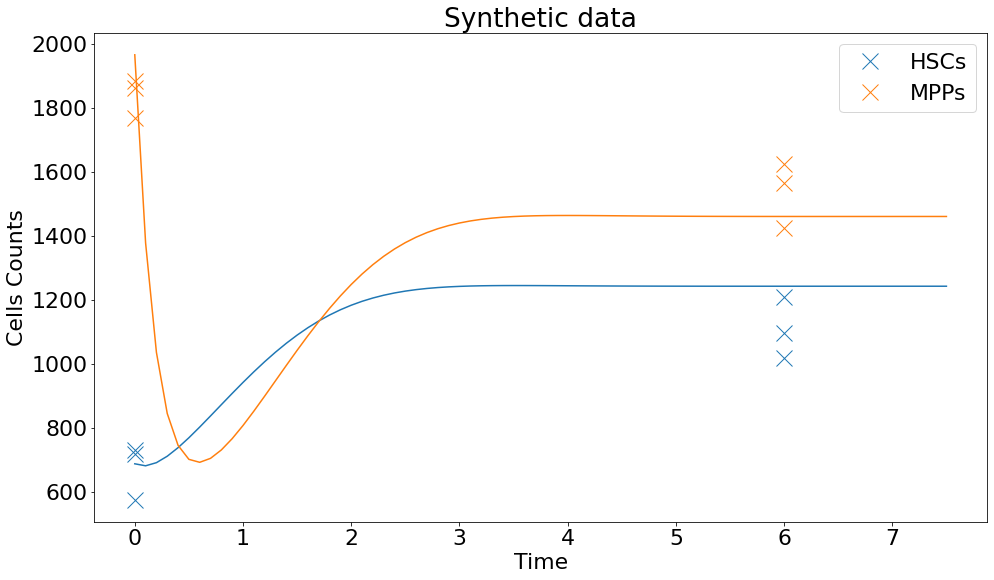

In [6]:
plt.figure(figsize=(16,9))
time = np.sort(np.tile(data_dict['days_data'], data_dict['dpts']))

plt.plot(data_dict['t'], two_cell.y_hat[:,0], color=u'#1f77b4',alpha=1)
plt.plot(data_dict['t'], two_cell.y_hat[:,1], color=u'#ff7f0e',alpha=1)
plt.plot(time, two_cell.y_noisy_time_series[:,0], 'x', markersize=16, 
         color=u'#1f77b4', label="HSCs")
plt.plot(time, two_cell.y_noisy_time_series[:,1], 'x', markersize=16, 
         color=u'#ff7f0e', label="MPPs")
plt.legend(loc="best")
plt.xlabel("Time");
plt.ylabel("Cells Counts");
plt.title("Synthetic data");

# Inverse problem

## Define priors 

In [7]:
priors_params = (
  dict(          
    p0max_prior_params=[-3.17, 0.91], # prior_logit(zlow=0.52, zhigh=0.6, lb=0.5, ub=1, qlow=0.5, qhigh=0.975,plot=T)
    eta1_prior_params=[1.35, 0.69], # prior_lognormal(zlow=1, zhigh=15, qlow=0.025, qhigh=0.975,plot=T)
    eta2maxbar_prior_params=[1.5, 0.76], # prior_lognormal(zlow=7, zhigh=20, qlow=0.5, qhigh=0.975,plot=T)
    gam1_prior_params=[1.15, 0.59], # prior_lognormal(zlow=1, zhigh=10, qlow=0.025, qhigh=0.975,plot=T)
    gam5_prior_params=[1.15,0.59],# prior_lognormal(zlow=2.5, zhigh=5, qlow=0.5, qhigh=0.975,plot=T)
    sigmate_prior_params=[-3.2, 0.74],# prior_lognormal(zlow=0.01, zhigh=1, qlow=0.025, qhigh=0.99999,plot=T)
    sigmabe_prior_params=[-3.2, 0.74], # prior_lognormal(zlow=0.01, zhigh=1, qlow=0.025, qhigh=0.99999,plot=T)
    mu_sc_prior_params=[6.55, 0.12], # prior_lognormal(zlow=7e2, zhigh=1.2e3, qlow=0.5, qhigh=0.99999,plot=T)
    mu_tc_prior_params=[7.6, 0.16] # prior_lognormal(zlow=2e3, zhigh=4e3, qlow=0.5, qhigh=0.99999,plot=T)
  )
)

Define STAN data

In [8]:
stan_data = (
  dict(
    t0 = data_dict["t"][0].tolist(),
    N_ts = len(data_dict["t"][1:]),
    ts = data_dict["t"][1:].tolist(), # All ODE solution times except time t0
    eps = [1e-6, 1e-6],  # epsilon added to ODE solution to make it non-negative when it's solved in STAN
    verbose = 0
  )
)
stan_data.update(priors_params)

Specify other variables for passing to STAN solver

In [9]:
dict_N_obs = (
  dict(
    N_obs_ic=data_dict["dpts"],
    N_obs_post_ic=data_dict["dpts"] * len(data_dict["days_data"][1:]),
    index_times_mice=np.repeat(data_dict["days_data_index_in_ts"][1:],
                                repeats=data_dict["dpts"]).tolist(),
    N_rep_pday = [data_dict['dpts']] * len(data_dict['days_data'])
  )
)
stan_data.update(dict_N_obs)
stan_data['TOT_OBS'] = stan_data["N_obs_ic"] + stan_data["N_obs_post_ic"]
stan_data["y_obs"] = np.zeros((stan_data["TOT_OBS"],2)).tolist()
stan_data["priors_only_flag"] = 1
stan_data.keys()

dict_keys(['t0', 'N_ts', 'ts', 'eps', 'verbose', 'p0max_prior_params', 'eta1_prior_params', 'eta2maxbar_prior_params', 'gam1_prior_params', 'gam5_prior_params', 'sigmate_prior_params', 'sigmabe_prior_params', 'mu_sc_prior_params', 'mu_tc_prior_params', 'N_obs_ic', 'N_obs_post_ic', 'index_times_mice', 'N_rep_pday', 'TOT_OBS', 'y_obs', 'priors_only_flag'])

For sampling ODE solutions from the priors, we make `y_obs` a vector of zeros since we do not have any observed data yet

In [10]:
rstan_data = NCmisc.Unlist(robjects.ListVector(stan_data))
r_global["rstan_data"] = rstan_data
r_run("""matrix(unlist(rstan_data["y_obs"]),
                nrow=(unlist(rstan_data["N_obs_ic"])
                          + unlist(rstan_data["N_obs_post_ic"])),
                ncol=2) -> rstan_data[["y_obs"]] """)
r_run(f'mcmc_priors_rdata_file = "{work_dir_demo}mcmc_prior_rdata_file.RData"')
r_run('save(rstan_data, file=mcmc_priors_rdata_file)')

rstan_data = robjects.r["rstan_data"]

## STAN model

In [48]:
str_stan_model = """//// Script for Full Bayes inference of 2 cells lineage ODE model////

functions {
   real[] two_cell_system(real t, real[] y, real[] theta,
                            real[] x_r, int[] x_i) {
     real p0max; real eta1;
     real eta2maxbar;
     real gam1; real gam5;

     real dy_dt[2];
     p0max = theta[1];
     eta1 = theta[2];
     eta2maxbar = theta[3];
     gam1 = theta[4] * 1e-5;
     gam5 = theta[5] * 1e-4;

     dy_dt[1]  = (2*(p0max/(1 + gam1 * y[2])) - 1) * eta1 * y[1];
     dy_dt[2]  = 2*(1-(p0max/(1+gam1 * y[2])))*eta1*y[1] - y[2] * (eta2maxbar/(1 + gam5 * y[1]));
     return dy_dt;
   }
 } 

data {
   real t0;                      // initial time
   int<lower=0> N_ts;             // Number of ODE solution times
   real<lower=t0> ts[N_ts];       // ODE solution times t1,...,tf

   //Assume both HSC and MPPs observed at same time, ie, have the same number of records
   int N_obs_ic;            // Total number of observations at t0 for each cell subpop
   int N_obs_post_ic;         // Total number of observations after t0 for each cell subpop

   int index_times_mice[N_obs_post_ic];  // Index of observations in ts after t0

   real y_obs[N_obs_ic+N_obs_post_ic, 2];    // All observed records both cell subpop

   real eps[2];

   real p0max_prior_params[2];
   real eta1_prior_params[2];
   real eta2maxbar_prior_params[2];
   real gam1_prior_params[2];
   real gam5_prior_params[2];

   real mu_sc_prior_params[2];
   real mu_tc_prior_params[2];

   real sigmate_prior_params[2];
   real sigmabe_prior_params[2];

   int priors_only_flag;        // 0 or 1, wheter sample from the priors only without likelihood block
   int verbose;                 // 0 or 1, wheter print ODE solver parameters for debugging
}

transformed data {
   real x_r[0];                 // no real data for ODE system
   int x_i[0];                  // no integer data for ODE system
   real theta_mean[5];
   real theta_std[5];
   real sigma_mean[2];
   real sigma_std[2];
   real mu_mean[2];
   real mu_std[2];

   theta_mean[1] = p0max_prior_params[1];
   theta_mean[2] = eta1_prior_params[1];
   theta_mean[3] = eta2maxbar_prior_params[1];
   theta_mean[4] = gam1_prior_params[1];
   theta_mean[5] = gam5_prior_params[1];
   theta_std[1] = p0max_prior_params[2];
   theta_std[2] = eta1_prior_params[2];
   theta_std[3] = eta2maxbar_prior_params[2];
   theta_std[4] = gam1_prior_params[2];
   theta_std[5] = gam5_prior_params[2];

   sigma_mean[1] = sigmabe_prior_params[1];
   sigma_mean[2] = sigmate_prior_params[1];
   sigma_std[1] = sigmabe_prior_params[2];
   sigma_std[2] = sigmate_prior_params[2];

   mu_mean[1] = mu_sc_prior_params[1];
   mu_mean[2] = mu_tc_prior_params[1];
   mu_std[1] = mu_sc_prior_params[2];
   mu_std[2] = mu_tc_prior_params[2];
}

parameters{
  real log_theta_raw[5];
  real log_sigma_raw[2];
  real log_mu_raw[2];
  vector[N_obs_post_ic] log_ylatent_sc_raw; //latent vars @ y[t1] and y[t2] SC
  vector[N_obs_post_ic] log_ylatent_tc_raw; //latent vars @ y[t1] and y[t2] TC
}

transformed parameters{
   real y_hat[N_obs_post_ic, N_ts, 2];
   real theta[5];
   real sigma[2];
   real log_mu[2];
   vector<lower=0>[N_obs_post_ic] ylatent_sc;
   vector<lower=0>[N_obs_post_ic] ylatent_tc;

   theta[1] = 0.5 + 0.5*inv_logit(theta_mean[1] + log_theta_raw[1]*theta_std[1]);
   for (i in 2:5){theta[i] = exp(theta_mean[i]+ log_theta_raw[i]*theta_std[i]);}

   for (i in 1:2){sigma[i] = exp(sigma_mean[i] + log_sigma_raw[i]*sigma_std[i]);}

   for (i in 1:2){log_mu[i] = mu_mean[i] + log_mu_raw[i]*mu_std[i];}

   ylatent_sc = exp(log_mu[1] + log_ylatent_sc_raw*sqrt(sigma[1]^2 + sigma[2]^2));
   ylatent_tc = exp(log_mu[2] + log_ylatent_tc_raw*sqrt(sigma[1]^2 + sigma[2]^2));
     {
     real y0[2];
     for (i in 1:N_obs_post_ic){
         y0[1] = ylatent_sc[i];
         y0[2] = ylatent_tc[i];
         y_hat[i,,] = integrate_ode_rk45(two_cell_system, y0, t0, ts, theta, x_r, x_i); }
     }
}

model {
   // Model priors
   // ODE param
   log_theta_raw ~ normal(0, 1);

   //IC Mean
    log_mu_raw ~  normal(0, 1);

   // Noise
    log_sigma_raw ~  normal(0, 1);

   //latent vars priors
    log_ylatent_sc_raw ~ normal(0, 1);
    log_ylatent_tc_raw ~ normal(0, 1);

    if (priors_only_flag == 0){
      // Likelihood
      y_obs[1:N_obs_ic, 1] ~ normal(log_mu[1], sqrt(sigma[1]^2 + sigma[2]^2));
      y_obs[1:N_obs_ic, 2] ~ normal(log_mu[2], sqrt(sigma[1]^2 + sigma[2]^2));

      for (i in 1:N_obs_post_ic){
        y_obs[N_obs_ic + i, 1] ~ normal(log(y_hat[i, index_times_mice[i], 1] + eps[1]), sigma[2]);
        y_obs[N_obs_ic + i, 2] ~ normal(log(y_hat[i, index_times_mice[i], 2] + eps[2]), sigma[2]);
          // For debugging purposes:
          if (verbose == 1){
            print("i = ", i)
            print("y0 = ", ylatent_sc[i], ", ", ylatent_tc[i])
            print("mu[1]: ", exp(log_mu[1]), ", mu[2]:", exp(log_mu[2]))
            print("i + N_obs_ic = ", i + N_obs_ic)
            print("y_obs[", i + N_obs_ic, "]= ", y_obs[i + N_obs_ic])
            print("index_times_mice[",i,"] = ", index_times_mice[i])
            print("y_hat[index_times_mice[i]] = ", y_hat[i, index_times_mice[i]])
            // print("p0max, eta1, p1 = ", p0max, ", ", eta1, ", ", p1)
            print("p0max, eta1 = ", theta[1], ", ", theta[2])
            // print("eta2max, gam1, gam5 = ", eta2max, ", ", gam1, ", ", gam5)
            print("eta2maxbar, gam1, gam5 = ", theta[3], ", ", theta[4], ", ", theta[5])
            print("sigmate = ", sigma[1])
            print("sigmabe = ", sigma[2])
            // print("y_hat = ", y_hat)
            print("-----------")
          }
      }
    }
}

generated quantities{
    real y_tilde[N_obs_ic+N_obs_post_ic, 2];
    real y_hat_tilde[N_ts, 2];
    real<lower=0.5, upper=1> p0max = theta[1];
    real<lower=0> eta1 = theta[2];
    real<lower=0> eta2maxbar = theta[3];
    real<lower=0> gam1 = theta[4];
    real<lower=0> gam5 = theta[5];
    real<lower=0> sigmate = sigma[1];
    real<lower=0> sigmabe = sigma[2];
    real<lower=0> mu[2] = exp(log_mu);

      for (i in 1:N_obs_ic){
        y_tilde[i, 1] = normal_rng(log_mu[1], sqrt(sigma[1]^2 + sigma[2]^2));
        y_tilde[i, 2] = normal_rng(log_mu[2], sqrt(sigma[1]^2 + sigma[2]^2));
      }
      for (i in 1:(N_obs_post_ic)){
        y_tilde[N_obs_ic + i, 1] = normal_rng(log(y_hat[i, index_times_mice[i], 1]+eps[1]), sigmate);
        y_tilde[N_obs_ic + i, 2] = normal_rng(log(y_hat[i, index_times_mice[i], 2]+eps[2]), sigmate);
      }
      {
      real y0[2];
      y0[1] = mu[1];
      y0[2] = mu[2];
      y_hat_tilde = integrate_ode_rk45(two_cell_system, y0, t0, ts, theta, x_r, x_i);
    }
}

"""

with open('model_two_celltypes.stan', 'w') as text_file:
  text_file.write(str_stan_model)

!cat model_two_celltypes.stan

//// Script for Full Bayes inference of 2 cells lineage ODE model////

functions {
   real[] two_cell_system(real t, real[] y, real[] theta,
                            real[] x_r, int[] x_i) {
     real p0max; real eta1;
     real eta2maxbar;
     real gam1; real gam5;

     real dy_dt[2];
     p0max = theta[1];
     eta1 = theta[2];
     eta2maxbar = theta[3];
     gam1 = theta[4] * 1e-5;
     gam5 = theta[5] * 1e-4;

     dy_dt[1]  = (2*(p0max/(1 + gam1 * y[2])) - 1) * eta1 * y[1];
     dy_dt[2]  = 2*(1-(p0max/(1+gam1 * y[2])))*eta1*y[1] - y[2] * (eta2maxbar/(1 + gam5 * y[1]));
     return dy_dt;
   }
 } 

data {
   real t0;                      // initial time
   int<lower=0> N_ts;             // Number of ODE solution times
   real<lower=t0> ts[N_ts];       // ODE solution times t1,...,tf

   //Assume both HSC and MPPs observed at same time, ie, have the same number of records
   int N_obs_ic;            // Total number of observations at t0 for each cell subpop
   int N_obs_post_

## (RUN) Load STAN model RDS file

Create a string with R commands and save them to a txt file with `.R` extension. 
The purpose is to create a STAN RDS file by compiling the STAN model or load the RDS file that was previously compiled

In [55]:
COMPILE = "FALSE"
SAVE_RDS = "FALSE"

str_stan_load_rds = f"""
library(rstan)
options(mc.cores = parallel::detectCores(), width=700)
rstan_options("auto_write" = TRUE)

COMPILE = {COMPILE}

work_dir_src = '{work_dir_src}';
work_dir_demo = '{work_dir_demo}';
work_dir_simulated_in_demo = '{work_dir_simulated_in_demo}';
work_dir_demo_simulated_before = '{work_dir_demo_simulated_before}';

stan_model_rds = paste0(work_dir_simulated_in_demo, 'model_two_celltypes.RDS');
stan_model_file = paste0(work_dir_demo, 'model_two_celltypes.stan');

print(stan_model_rds)
print(stan_model_file)

if (isTRUE(COMPILE)){{
  print('Compiling STAN model...')
  file.exists(stan_model_file);
  fit_obj = stan_model(file = stan_model_file);
  print('Compilation RDS Stan model successful!')
  if (isTRUE({SAVE_RDS})){{ 
    saveRDS(object = fit_obj, file = stan_model_rds);
    print('Saving of RDS Stan model successful!')
  }}  

}} else {{
  fit_obj = readRDS(file = stan_model_rds);
  print('Loading of RDS Stan model successful!')
}}
"""

with open('r_stan_load_rds.R', 'w') as text_file:
  text_file.write(str_stan_load_rds)

!cat r_stan_load_rds.R


library(rstan)
options(mc.cores = parallel::detectCores(), width=700)
rstan_options("auto_write" = TRUE)

COMPILE = FALSE

work_dir_src = '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/';
work_dir_demo = '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/';
work_dir_simulated_in_demo = '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_in_demo/';
work_dir_demo_simulated_before = '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_before/';

stan_model_rds = paste0(work_dir_simulated_in_demo, 'model_two_celltypes.RDS');
stan_model_file = paste0(work_dir_demo, 'model_two_celltypes.stan');

print(stan_model_rds)
print(stan_model_file)

if (isTRUE(COMPILE)){
  print('Compiling STAN model...')
  file.exists(stan_model_file);
  fit_obj = stan_model(file = stan_model_file);
  print('Compilation RDS Stan model successful!')
  if (isTRUE(FALSE)){ 
  

Run the R script

In [56]:
!Rscript r_stan_load_rds.R

Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
[1] "/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_in_demo/model_two_celltypes.RDS"
[1] "/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/model_two_celltypes.stan"
[1] "Loading of RDS Stan model successful!"


## Initial values for MCMC chains

The initial values for the chains need to be specified using a random unifor distribution in the range that makes sense for each parameter. Note that this step is required to initialize the chains in regions that make sense for the ODE solution, otherwise aberrant ODE solutions can lead to overflow errors in STAN.



In [57]:
r_global["N_mice_t_days_data"] = stan_data["N_obs_post_ic"]

str_stan_inits = f"""
N_mice_t_days_data = {stan_data["N_obs_post_ic"]};
stan_inits = function(){{
  list(logit_p0max_raw=runif(1,-2,0), #instead of runif(1,-2, 2) since they are standard normals in log scale
        log_eta1_raw=runif(1,-2,0),
        log_eta2maxbar=runif(1,-2,0),
        log_gam1_raw=runif(1,-2,0),
        log_gam5_raw=runif(1,-2,0),
        log_sigmate_raw=runif(1,-2,0),
        log_sigmabe_raw=runif(1,-2,0),
        log_mu_raw=runif(2,-2,0),
        log_ylatent_sc_raw=runif(N_mice_t_days_data,-2,0),
        log_ylatent_sc_raw=runif(N_mice_t_days_data,-2,0),
        y_hat=matrix(runif(N_mice_t_days_data*2,1e2,4e3), nrow=N_mice_t_days_data, ncol=2),
        p0max=runif(1,0.5,0.6),
        eta1=runif(1,1,5),
        eta2maxbar=runif(1,0.1,1),
        gam1=runif(1,1,4),
        gam5=runif(1,1,4),
        sigmate=runif(1,0,0.1),
        sigmabe=runif(1,0,0.1),
        mu=runif(2, c(1e2,1e2), c(2e3,4e3)),
        ylatent_sc=runif(N_mice_t_days_data,1e2,2e3),
        ylatent_tc=runif(N_mice_t_days_data,1e2,4e3))}};

"""
!cat r_stan_inits.R
with open('r_stan_inits.R', 'w') as text_file:
  text_file.write(str_stan_inits)



N_mice_t_days_data = 3;
stan_inits = function(){
  list(logit_p0max_raw=runif(1,-2,0), #instead of runif(1,-2, 2) since they are standard normals in log scale
        log_eta1_raw=runif(1,-2,0),
        log_eta2maxbar=runif(1,-2,0),
        log_gam1_raw=runif(1,-2,0),
        log_gam5_raw=runif(1,-2,0),
        log_sigmate_raw=runif(1,-2,0),
        log_sigmabe_raw=runif(1,-2,0),
        log_mu_raw=runif(2,-2,0),
        log_ylatent_sc_raw=runif(N_mice_t_days_data,-2,0),
        log_ylatent_sc_raw=runif(N_mice_t_days_data,-2,0),
        y_hat=matrix(runif(N_mice_t_days_data*2,1e2,4e3), nrow=N_mice_t_days_data, ncol=2),
        p0max=runif(1,0.5,0.6),
        eta1=runif(1,1,5),
        eta2maxbar=runif(1,0.1,1),
        gam1=runif(1,1,4),
        gam5=runif(1,1,4),
        sigmate=runif(1,0,0.1),
        sigmabe=runif(1,0,0.1),
        mu=runif(2, c(1e2,1e2), c(2e3,4e3)),
        ylatent_sc=runif(N_mice_t_days_data,1e2,2e3),
        ylatent_tc=runif(N_mice_t_days_data,1e2,4e3))};



## Priors MCMC

Define the run configuration dictionary to run STAN and sample from the priors only. To run full MCMC iterations set `TEST_RESCALING_FACTOR = 1`

In [58]:
TEST_RESCALING_FACTOR = 1

run_conf = (
  dict(num_MCMC_iter=5000//TEST_RESCALING_FACTOR,
    num_chains=2,
    num_warmup=1000//TEST_RESCALING_FACTOR,
    create_file_samples_csv=True, # False
    MCMC_type='Stan',
    priors_only=True,
    seed=1234,
    verbose=0,
    file_samples_priors_csv=(
        work_dir_simulated_in_demo + 'Stan_samples_priors.csv'
    ),
  )
)
run_conf['num_samples_MCMC'] = (
  (run_conf['num_MCMC_iter'] - run_conf['num_warmup']) * run_conf['num_chains']
)
run_conf['fit_priors_ignored_params'] = ['y_hat', 'log_theta_raw', 'log_mu_raw', 
                                    'log_ylatent_tc_raw', 'log_ylatent_sc_raw']

run_conf['pars_ode_noise'] = ['p0max', 'eta1', 'eta2maxbar', 'gam1', 'gam5', 
                              'sigmate', 'sigmabe', 'mu', 'lp__']
run_conf['pars_ylatent'] = ["ylatent_tc", "ylatent_sc"]

print(run_conf)

{'num_MCMC_iter': 5000, 'num_chains': 2, 'num_warmup': 1000, 'create_file_samples_csv': True, 'MCMC_type': 'Stan', 'priors_only': True, 'seed': 1234, 'verbose': 0, 'file_samples_priors_csv': '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_in_demo/Stan_samples_priors.csv', 'num_samples_MCMC': 8000, 'fit_priors_ignored_params': ['y_hat', 'log_theta_raw', 'log_mu_raw', 'log_ylatent_tc_raw', 'log_ylatent_sc_raw'], 'pars_ode_noise': ['p0max', 'eta1', 'eta2maxbar', 'gam1', 'gam5', 'sigmate', 'sigmabe', 'mu', 'lp__'], 'pars_ylatent': ['ylatent_tc', 'ylatent_sc']}


In [59]:
r_run_conf = NCmisc.Unlist(robjects.ListVector(run_conf))
r_global["run_conf"] = r_run_conf
r_run(f'mcmc_run_conf_file = "{work_dir_demo}mcmc_run_conf.RData"')
r_run('save(run_conf, file=mcmc_run_conf_file)')

rpy2.rinterface.NULL

### Run MCMC

Create R file for running priors sampling only

In [60]:
str_mcmc_priors = f"""
setwd('{work_dir_demo}')
#.libPaths( c('{r_lib_loc}' , .libPaths() )) 
#print(.libPaths())

library(rstan)
options(mc.cores = parallel::detectCores(), width=700)
rstan_options("auto_write" = TRUE)

load('mcmc_prior_rdata_file.RData')
load('mcmc_run_conf.RData')

source('r_stan_inits.R')
source('r_load_stan_rds.R')


pars_ode_noise = c('p0max', 'eta1', 'eta2maxbar', 'gam1', 'gam5', 'sigmate', 
                    'sigmabe', 'mu', 'lp__')

pars_ylatent = c("ylatent_tc", "ylatent_sc")

print(rstan_data)

fit_priors = sampling(
    object=fit_obj,
    data=rstan_data,
    chains=as.numeric(run_conf['num_chains']),
    iter=as.numeric(run_conf['num_MCMC_iter']),
    warmup=as.numeric(run_conf['num_warmup']),
    sample_file=as.character(run_conf['file_samples_priors_csv']),
    # diagnostic_file=run_conf['file_sampling_diagn_priors_csv'],
    seed=as.numeric(run_conf['seed']),
    init=stan_inits,
    verbose=FALSE,
    open_progress=FALSE, #no html file open for inspection
    show_messages=TRUE,
    include=FALSE,
    pars=run_conf['fit_priors_ignored_params']
)

print(fit_priors, pars=pars_ode_noise)
"""
with open('r_mcmc_priors.R', 'w') as text_file:
  text_file.write(str_mcmc_priors)

!cat r_mcmc_priors.R



setwd('/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/')
#.libPaths( c('/home/luisdm/.conda/envs/tfgpu_rpy2_20200628/lib/R/library' , .libPaths() )) 
#print(.libPaths())

library(rstan)
options(mc.cores = parallel::detectCores(), width=700)
rstan_options("auto_write" = TRUE)

load('mcmc_prior_rdata_file.RData')
load('mcmc_run_conf.RData')

source('r_stan_inits.R')
source('r_load_stan_rds.R')


pars_ode_noise = c('p0max', 'eta1', 'eta2maxbar', 'gam1', 'gam5', 'sigmate', 
                    'sigmabe', 'mu', 'lp__')

pars_ylatent = c("ylatent_tc", "ylatent_sc")

print(rstan_data)

fit_priors = sampling(
    object=fit_obj,
    data=rstan_data,
    chains=as.numeric(run_conf['num_chains']),
    iter=as.numeric(run_conf['num_MCMC_iter']),
    warmup=as.numeric(run_conf['num_warmup']),
    sample_file=as.character(run_conf['file_samples_priors_csv']),
    # diagnostic_file=run_conf['file_sampling_diagn_priors_csv'],
    seed=as.numeric(run_conf['seed']),


In [ ]:
!Rscript r_mcmc_priors.R

Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
[1] "Loading of RDS Stan model successful!"
$t0
[1] 0

$N_ts
[1] 75

$ts
 [1] 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.0 2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.0 3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.0 4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.0 5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9 6.0 6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.0 7.1 7.2 7.3 7.4 7.5

$eps
[1] 1e-06 1e-06

$verbose
[1] 0

$p0max_prior_params
[1] -3.17  0.91

$eta1_prior_params
[1] 1.35 0.69

$eta2maxbar_prior_params
[1]

## Posteriors MCMC

Update `stan_data` dictionary with the information needed to run STAN using the noisy time series data simulated in the Forward section above

In [61]:
stan_data["priors_only_flag"] = 0
stan_data["y_obs"] = ynoisy.tolist()
print(stan_data)

{'t0': 0.0, 'N_ts': 75, 'ts': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0, 3.1, 3.2, 3.3000000000000003, 3.4000000000000004, 3.5, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.0, 4.1000000000000005, 4.2, 4.3, 4.4, 4.5, 4.6000000000000005, 4.7, 4.800000000000001, 4.9, 5.0, 5.1000000000000005, 5.2, 5.300000000000001, 5.4, 5.5, 5.6000000000000005, 5.7, 5.800000000000001, 5.9, 6.0, 6.1000000000000005, 6.2, 6.300000000000001, 6.4, 6.5, 6.6000000000000005, 6.7, 6.800000000000001, 6.9, 7.0, 7.1000000000000005, 7.2, 7.300000000000001, 7.4, 7.5], 'eps': [1e-06, 1e-06], 'verbose': 0, 'p0max_prior_params': [-3.17, 0.91], 'eta1_prior_params': [1.35, 0.69], 'eta2maxbar_prior_params': [1.5, 0.76], 'gam1_prior_params': [1.15, 0

In [62]:
rstan_data = NCmisc.Unlist(robjects.ListVector(stan_data))
r_global["rstan_data"] = rstan_data
r_run("""matrix(unlist(rstan_data["y_obs"]),
                nrow=(unlist(rstan_data["N_obs_ic"])
                          + unlist(rstan_data["N_obs_post_ic"])),
                ncol=2) -> rstan_data[["y_obs"]] """)
rstan_data = robjects.r["rstan_data"]


rstan_data = NCmisc.Unlist(robjects.ListVector(stan_data))
r_global["rstan_data"] = rstan_data
r_run("""matrix(unlist(rstan_data["y_obs"]),
                nrow=(unlist(rstan_data["N_obs_ic"])
                          + unlist(rstan_data["N_obs_post_ic"])),
                ncol=2) -> rstan_data[["y_obs"]] """)

r_run(f'mcmc_posteriors_rdata_file = "{work_dir_demo}mcmc_posteriors_rdata_file.RData"')
r_run('save(rstan_data, file=mcmc_posteriors_rdata_file)')

rstan_data = robjects.r["rstan_data"]
rstan_data

R object with classes: ('list',) mapped to:
<ListVector - Python:0x7fd7df1df0a0 / R:0x55afc5f55880>
[FloatVector, IntVector, FloatVector, FloatVector, ..., IntVector, IntVector, Matrix, IntVector]
  t0: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7fd7df1dfdc0 / R:0x55afc652dda8>
[0.000000]
  N_ts: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7fd7df389e10 / R:0x55afc652dd70>
[75]
  ts: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7fd7df3a1280 / R:0x55afc5efd240>
[0.100000, 0.200000, 0.300000, 0.400000, ..., 7.200000, 7.300000, 7.400000, 7.500000]
  eps: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7fd7df1dfaf0 / R:0x55afc65312f8>
[0.000001, 0.000001]
...
  p0max_prior_params: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7fd7df21eeb0 / R:0x55afc652dc90>
[3, 3]
  eta1_prior_params: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7fd7df33ca50 / R:0x55afc652dc58>
[6]
  eta2maxbar_prior_params: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7fd7df2602d0 / R:0x55afc5d9bfb8>
[718.683415, 1862.616041, 728.807213, 1767.863023, ..., 1096.018382, 1424.621508, 1016.054192, 1564.583643]
  gam1_prior_params: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7fd7df33c9b0 / R:0x55afc652dc20>
[0]

Specify posterior distributions sampling using `priors_only` flag. To run all MCMC simulation set `TEST_RESCALING_FACTOR=1` 

In [63]:
TEST_RESCALING_FACTOR = 1

run_conf['priors_only'] = 0

run_conf['num_MCMC_iter'] = 5000//TEST_RESCALING_FACTOR
run_conf['num_chains'] = 2
run_conf['num_warmup'] = 1000//TEST_RESCALING_FACTOR
run_conf['seed'] = 12345
run_conf['verbose'] = 0

run_conf['file_samples_posteriors_csv']= (
  work_dir_simulated_in_demo +  'Stan_samples_posteriors.csv'
)
run_conf['num_samples_MCMC'] = (
  (run_conf['num_MCMC_iter'] - run_conf['num_warmup']) * run_conf['num_chains']
)

print(run_conf)
run_conf['fit_ignored_params'] = ['y_hat']

r_run_conf = NCmisc.Unlist(robjects.ListVector(run_conf))
r_global["run_conf"] = r_run_conf
r_run(f'mcmc_run_conf_file = "{work_dir_demo}mcmc_run_conf.RData"')
r_run('save(run_conf, file=mcmc_run_conf_file)')

{'num_MCMC_iter': 5000, 'num_chains': 2, 'num_warmup': 1000, 'create_file_samples_csv': True, 'MCMC_type': 'Stan', 'priors_only': 0, 'seed': 12345, 'verbose': 0, 'file_samples_priors_csv': '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_in_demo/Stan_samples_priors.csv', 'num_samples_MCMC': 8000, 'fit_priors_ignored_params': ['y_hat', 'log_theta_raw', 'log_mu_raw', 'log_ylatent_tc_raw', 'log_ylatent_sc_raw'], 'pars_ode_noise': ['p0max', 'eta1', 'eta2maxbar', 'gam1', 'gam5', 'sigmate', 'sigmabe', 'mu', 'lp__'], 'pars_ylatent': ['ylatent_tc', 'ylatent_sc'], 'file_samples_posteriors_csv': '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_in_demo/Stan_samples_posteriors.csv'}


rpy2.rinterface.NULL

In [64]:
str_mcmc_posteriors = f"""
setwd('{work_dir_demo}')
library(rstan)
options(mc.cores = parallel::detectCores(), width=700)
rstan_options("auto_write" = TRUE)

load('mcmc_posteriors_rdata_file.RData')
load('mcmc_run_conf.RData')

source('r_stan_inits.R')
source('r_load_stan_rds.R')


pars_ode_noise = c('p0max', 'eta1', 'eta2maxbar', 'gam1', 'gam5', 'sigmate', 
                    'sigmabe', 'mu', 'lp__')

pars_ylatent = c("ylatent_tc", "ylatent_sc")
print(rstan_data)
print(run_conf)
fit_posteriors = sampling(
    object=fit_obj,
    data=rstan_data,
    chains=as.numeric(run_conf['num_chains']),
    iter=as.numeric(run_conf['num_MCMC_iter']),
    warmup=as.numeric(run_conf['num_warmup']),
    sample_file=as.character(run_conf['file_samples_posteriors_csv']),
    seed=as.numeric(run_conf['seed']),
    init=stan_inits,
    verbose=FALSE,
    open_progress=FALSE, #no html file open for inspection
    show_messages=TRUE,
    include=FALSE,
    pars=run_conf['fit_priors_ignored_params']
)

print(fit_posteriors, pars=pars_ode_noise)
"""

with open('r_mcmc_posteriors.R', 'w') as text_file:
  text_file.write(str_mcmc_posteriors)

!cat r_mcmc_posteriors.R



setwd('/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/')
library(rstan)
options(mc.cores = parallel::detectCores(), width=700)
rstan_options("auto_write" = TRUE)

load('mcmc_posteriors_rdata_file.RData')
load('mcmc_run_conf.RData')

source('r_stan_inits.R')
source('r_load_stan_rds.R')


pars_ode_noise = c('p0max', 'eta1', 'eta2maxbar', 'gam1', 'gam5', 'sigmate', 
                    'sigmabe', 'mu', 'lp__')

pars_ylatent = c("ylatent_tc", "ylatent_sc")
print(rstan_data)
print(run_conf)
fit_posteriors = sampling(
    object=fit_obj,
    data=rstan_data,
    chains=as.numeric(run_conf['num_chains']),
    iter=as.numeric(run_conf['num_MCMC_iter']),
    warmup=as.numeric(run_conf['num_warmup']),
    sample_file=as.character(run_conf['file_samples_posteriors_csv']),
    seed=as.numeric(run_conf['seed']),
    init=stan_inits,
    verbose=FALSE,
    open_progress=FALSE, #no html file open for inspection
    show_messages=TRUE,
    include=FALSE,
    pars=ru

### Run MCMC

In [ ]:
!Rscript r_mcmc_posteriors.R

Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
[1] "Loading of RDS Stan model successful!"
$t0
[1] 0

$N_ts
[1] 75

$ts
 [1] 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.0 2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.0 3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.0 4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.0 5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9 6.0 6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.0 7.1 7.2 7.3 7.4 7.5

$eps
[1] 1e-06 1e-06

$verbose
[1] 0

$p0max_prior_params
[1] -3.17  0.91

$eta1_prior_params
[1] 1.35 0.69

$eta2maxbar_prior_params
[1]

## Predictive plots

For previously simulated mcmc samples

Load csv.zip files instead of using Stan fit object or the extracted samples. This way it's easier for one simulated chain and load the data with `Pandas`.

In [70]:
%ls /home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_before/

AERStan_0_nparam_57_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc.zip
bridge_object.RDS
dpts_6_times_01236_dataset_0.csv
dpts_6_times_01236_dataset_0_true.csv
dpts_6_times_01236_dataset_-1.csv
dpts_6_times_01236_dataset_-1_true.csv
param_sets.csv
Prior_vs_posterior.png
Stan_0_nparam_57_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc.zip
Stan_-1_nparam_57_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc_priors.zip
test_stan_model.RDS


In [ ]:
zip_priors = work_dir_demo_simulated_before + 'Stan_-1_nparam_57_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc_priors.zip'
zip_posteriors = work_dir_demo_simulated_before + 'Stan_0_nparam_57_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc.zip'
csv_params_sets = work_dir_demo_simulated_before + 'param_sets.csv'
csv_ynoisy = work_dir_demo_simulated_before + 'dpts_6_times_01236_dataset_0.csv'
csv_ytrue = work_dir_demo_simulated_before + 'dpts_6_times_01236_dataset_0_true.csv'

In [ ]:
NUM_WARMUP = 1000
NUM_SAMPLING = 5000
df_cols = ['lp__', 'p0max', 'eta1', 'eta2maxbar', 'gam1', 'gam5', 
           'sigmabe','sigmate', 'mu.1', 'mu.2']

param_sets_df = pd.read_csv(csv_params_sets, header=None)
param_sets_df.head()

true_values = {df_cols[ix] : param_sets_df.iloc[0, ix-1] for ix in range(1, len(df_cols))}
true_values['lp__'] = np.nan
true_values

{'p0max': 0.586485746432897,
 'eta1': 5.0840514526087235,
 'eta2maxbar': 9.429479207504697,
 'gam1': 11.84761981045478,
 'gam5': 9.505391977630259,
 'sigmabe': 0.019777988905055256,
 'sigmate': 0.08233701042138465,
 'mu.1': 686.6585378783957,
 'mu.2': 1965.4666631445841,
 'lp__': nan}

### Prior vs Posterior plots

In [ ]:
df_posteriors = pd.read_csv(zip_posteriors, comment='#')
print(df_posteriors.shape)
df_posteriors = df_posteriors.loc[:, df_posteriors.columns.isin(df_cols)]
df_posteriors = df_posteriors.loc[NUM_WARMUP:, :]
df_posteriors = df_posteriors.reset_index(drop=True)
print(df_posteriors.shape)
df_posteriors.head()

(6000, 3940)
(5000, 10)


,lp__,p0max,eta1,eta2maxbar,gam1,gam5,sigmate,sigmabe,mu.1,mu.2
0,171.251,0.599755,4.47647,8.23916,13.7830,9.52459,0.077885,0.017964,725.704,1911.93
1,166.729,0.597508,4.44731,7.86473,13.5373,8.63662,0.063178,0.017649,729.804,1912.09
2,165.791,0.600642,4.52062,7.44829,13.9459,7.49768,0.063841,0.015085,698.403,1902.86
3,161.847,0.599776,4.42089,7.60362,13.8107,8.14799,0.071133,0.018664,731.078,1924.46
4,165.999,0.589733,4.30486,10.16750,12.3925,14.35750,0.076105,0.019241,765.883,1907.60


In [ ]:
df_priors = pd.read_csv(zip_priors, comment='#')
print(df_priors.shape)
df_priors = df_priors.loc[:, df_priors.columns.isin(df_cols)]
df_priors = df_priors.iloc[NUM_WARMUP:, :]
df_priors = df_priors.reset_index(drop=True)
df_priors = df_priors
print(print(df_priors.shape))
df_priors.head()

(6000, 3940)
(5000, 10)
None


,lp__,p0max,eta1,eta2maxbar,gam1,gam5,sigmate,sigmabe,mu.1,mu.2
0,-30.6653,0.556401,1.71492,0.981348,2.72474,2.77506,0.016417,0.013902,807.183,2147.05
1,-29.5469,0.506998,8.59971,20.833800,3.56295,2.14231,0.086723,0.102388,605.577,1995.10
2,-33.5926,0.514381,5.40094,3.482910,2.48761,2.69274,0.006905,0.026819,556.161,2493.27
3,-34.1153,0.528964,2.88336,5.310480,4.21259,3.08389,0.273092,0.063508,880.704,1661.60
4,-37.2655,0.513676,8.53750,4.514700,1.66595,3.47274,0.006701,0.021009,534.509,2646.80


##### Plot

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


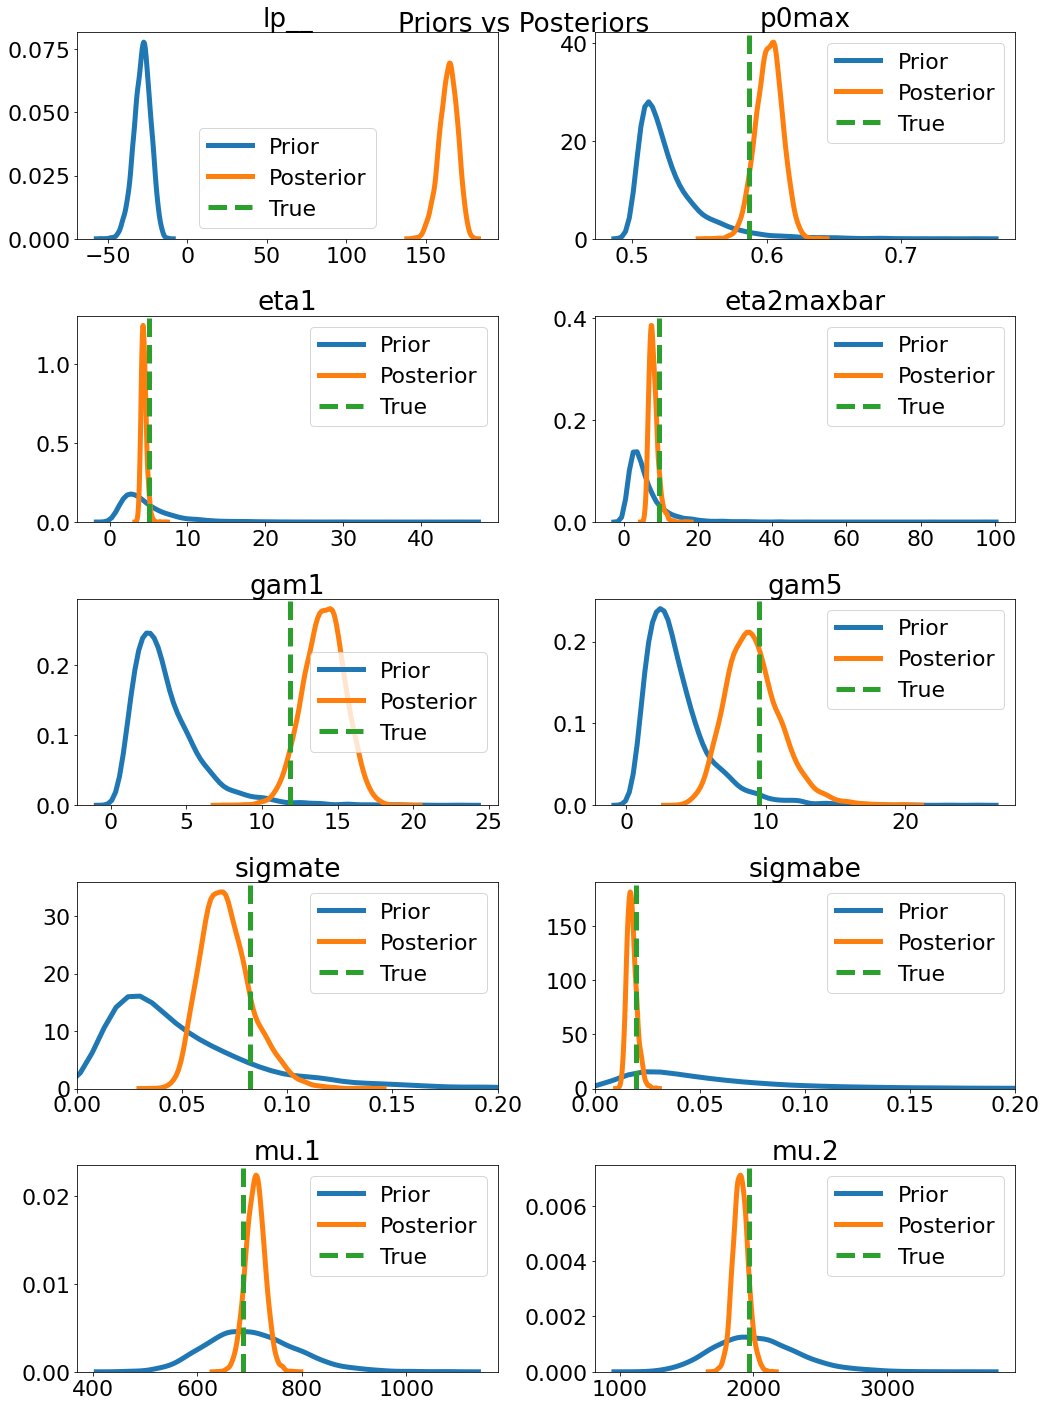

In [ ]:
plt.subplots(5,2, figsize=(15,20))
for subplot_ix, param in enumerate(df_posteriors.columns):
    plt.subplot(5, 2, subplot_ix+1)
    sns.kdeplot(df_priors.loc[:, param], linewidth=5,label="Prior")
    sns.kdeplot(df_posteriors.loc[:, param], linewidth=5, label="Posterior")
    plt.axvline(x=true_values[param], linestyle="--", linewidth=5,
                label="True", color=u'#2ca02c')
    if param in ["sigmabe", "sigmate"]:
        plt.xlim([0, 0.2])
    plt.legend(loc=0);
    plt.title(f"{param}")
plt.tight_layout()
plt.suptitle("Priors vs Posteriors\n");
plt.savefig(work_dir_demo_simulated_before + "Prior_vs_posterior.png", dpi=300)

### Prior and Posterior checks

In [ ]:
data_dict = {}
data_dict["days_data"] = [0,1,2,3,6]
data_dict['dpts'] = 6
stan_data = data_dict
stan_data["N_rep_pday"] = [data_dict['dpts']] * len(data_dict['days_data'])

In [ ]:
ytrue_df = pd.read_csv(csv_ytrue, header=None)
ytrue_df.columns = ['time', 'HSCs', 'MPPs', 'flag']
ytrue_df.head()
ytrue_df[ytrue_df.flag == 1]

,time,HSCs,MPPs,flag
0,0.0,686.658538,1965.466663,1.0
2,0.2,690.159243,1035.016272,1.0
5,0.5,768.055843,700.545065,1.0
10,1.0,941.014169,806.347098,1.0
20,2.0,1182.457044,1247.339624,1.0
30,3.0,1241.388901,1439.522731,1.0
40,4.0,1243.298980,1463.049168,1.0
50,5.0,1242.017151,1460.773523,1.0
60,6.0,1241.847704,1459.967694,1.0


In [ ]:
ynoisy_df = pd.read_csv(csv_ynoisy, header=None)
ynoisy_df.columns = ['HSCs', 'MPPs']
ynoisy_df.head()

,HSCs,MPPs
0,714.624941,1776.915400
1,775.228241,1914.113554
2,646.012156,2118.808443
3,738.503853,1862.331988
4,687.571820,1625.509220


In [ ]:
summary_percentiles = percentiles=[0.025, 0.5, 0.975]
df_posteriors = pd.read_csv(zip_posteriors, comment='#')
print(df_posteriors.shape)
df_posteriors = df_posteriors.filter(like='y_tilde')
df_posteriors = df_posteriors.loc[NUM_WARMUP:, :]
df_posteriors = df_posteriors.reset_index(drop=True)
df_posteriors = np.exp(df_posteriors)
df_posteriors.head()
print(df_posteriors.shape)

df_posteriors_y_tilde_summ = df_posteriors.describe(summary_percentiles)
df_posteriors_y_tilde_summ

(6000, 3940)
(5000, 60)


,y_tilde.1.1,y_tilde.2.1,y_tilde.3.1,y_tilde.4.1,y_tilde.5.1,y_tilde.6.1,y_tilde.7.1,y_tilde.8.1,y_tilde.9.1,y_tilde.10.1,...,y_tilde.21.2,y_tilde.22.2,y_tilde.23.2,y_tilde.24.2,y_tilde.25.2,y_tilde.26.2,y_tilde.27.2,y_tilde.28.2,y_tilde.29.2,y_tilde.30.2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,712.050709,712.968540,712.247413,712.535268,713.049671,712.931684,953.136859,906.167288,981.087510,932.827429,...,1439.007991,1437.232777,1438.476769,1434.506394,1445.270542,1445.550974,1445.119791,1446.625270,1445.740835,1444.373606
std,56.935350,56.241073,56.744260,56.117852,55.770316,56.597541,68.034588,67.600225,72.129680,69.094189,...,106.014384,106.372109,103.942019,104.148000,106.042473,106.161577,104.842676,103.681225,104.330679,105.033729
min,504.869510,467.294650,495.679724,488.060806,480.972454,530.632664,721.115991,641.673752,735.021683,694.811093,...,1090.509176,1013.221360,1054.782644,991.550619,1037.895101,1024.950912,1051.822865,1109.772147,943.682712,1091.589315
2.5%,608.132175,607.732459,605.380238,610.053861,608.870591,608.402549,824.847071,774.906984,848.122854,803.072303,...,1238.920854,1234.721542,1246.066415,1240.762950,1243.533249,1248.152204,1248.015227,1251.663193,1253.484442,1247.512071
50%,709.503195,710.888076,710.248565,710.205951,711.471244,710.966278,950.915305,904.534096,977.775408,930.572514,...,1436.234447,1433.952648,1435.207906,1431.517000,1441.767398,1441.868326,1441.017875,1441.789025,1442.192783,1439.548785
97.5%,832.227227,830.244512,829.502817,829.905219,826.525690,828.625042,1094.706150,1041.897665,1129.482396,1075.325302,...,1654.984630,1659.647899,1657.485130,1653.237474,1671.894181,1671.213026,1663.508991,1661.553856,1658.244023,1665.773736
max,1021.676312,988.372845,979.585967,1009.237122,1016.845025,1005.208237,1290.196743,1272.069016,1336.273435,1251.076926,...,2021.307787,1953.972971,1907.616813,1895.390187,1990.617159,1905.462423,1981.045471,1954.148837,1898.918894,1951.180787


In [ ]:
df_priors = pd.read_csv(zip_priors, comment='#')
print(df_priors.shape)
df_priors = df_priors.filter(like='y_tilde')
df_priors = df_priors.iloc[NUM_WARMUP:, :]
df_priors = df_priors.reset_index(drop=True)
df_priors = np.exp(df_priors)
print(df_priors.shape)

df_priors_y_tilde_summ = df_priors.describe(summary_percentiles)
df_priors_y_tilde_summ

(6000, 3940)
(5000, 60)


,y_tilde.1.1,y_tilde.2.1,y_tilde.3.1,y_tilde.4.1,y_tilde.5.1,y_tilde.6.1,y_tilde.7.1,y_tilde.8.1,y_tilde.9.1,y_tilde.10.1,...,y_tilde.21.2,y_tilde.22.2,y_tilde.23.2,y_tilde.24.2,y_tilde.25.2,y_tilde.26.2,y_tilde.27.2,y_tilde.28.2,y_tilde.29.2,y_tilde.30.2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,707.562432,707.552331,707.709472,708.820640,709.405814,707.597175,750.113962,748.149293,748.667362,747.324824,...,1341.026350,1339.526207,1341.567665,1339.546707,1578.929114,1589.308996,1574.556348,1579.348700,1576.086757,1576.669644
std,112.591146,110.449242,112.963123,114.610413,111.611530,110.672968,321.518098,320.656900,318.924680,319.866069,...,2311.131809,2302.111536,2378.023226,2319.598516,2330.839169,2361.869175,2304.772522,2295.774690,2307.910214,2313.040596
min,142.695073,229.839215,319.373096,147.743845,223.477335,309.519161,10.499000,9.223735,11.303247,10.438595,...,18.703113,18.337901,18.107931,19.931871,18.167422,20.086943,20.384198,19.692345,20.206210,19.917326
2.5%,514.763082,514.922551,513.281666,518.089889,519.428936,517.803078,299.880710,302.227421,299.327416,303.024850,...,114.790747,111.365436,112.377869,112.969055,132.807919,125.333734,126.944002,129.395905,131.279331,132.180702
50%,699.443487,699.156774,698.803789,700.479439,701.804588,699.702329,708.390159,706.197540,704.546972,701.973042,...,833.313566,832.339161,832.638855,828.502641,869.318969,879.400130,878.442120,868.041921,873.955990,870.710897
97.5%,950.541434,944.627812,948.298672,947.561176,954.444272,948.341818,1471.022476,1465.212794,1468.712726,1473.789524,...,5683.214882,5679.755128,5699.734186,5677.196110,7616.989568,7685.476696,7308.377430,7462.033576,7401.876818,7413.321077
max,1788.262934,1681.514240,1817.486897,3004.210249,1425.602770,1449.508772,6719.976927,6182.388720,5655.591609,6228.121242,...,76803.078272,78291.944755,84507.874639,79514.923499,48228.239007,46276.983507,46388.181652,43967.236037,45688.413006,43998.023877


In [ ]:
# Shift Time so 95% intervals do not overlap
time_pert = []
for timepoints, dpts in zip(data_dict["days_data"],
                            stan_data["N_rep_pday"]):
    time_pert.append(
        np.linspace(timepoints-0.1, timepoints+0.1, dpts).tolist()
    )
time_pert = sum(time_pert,[])
print(time_pert)

[-0.1, -0.060000000000000005, -0.020000000000000004, 0.01999999999999999, 0.06, 0.1, 0.9, 0.9400000000000001, 0.9800000000000001, 1.02, 1.06, 1.1, 1.9, 1.94, 1.98, 2.02, 2.06, 2.1, 2.9, 2.94, 2.98, 3.02, 3.06, 3.1, 5.9, 5.94, 5.98, 6.02, 6.06, 6.1]


In [ ]:
data_pert = ynoisy_df

##### Plot


Text(0.5, 0.98, 'Posteriors Pred Checks')

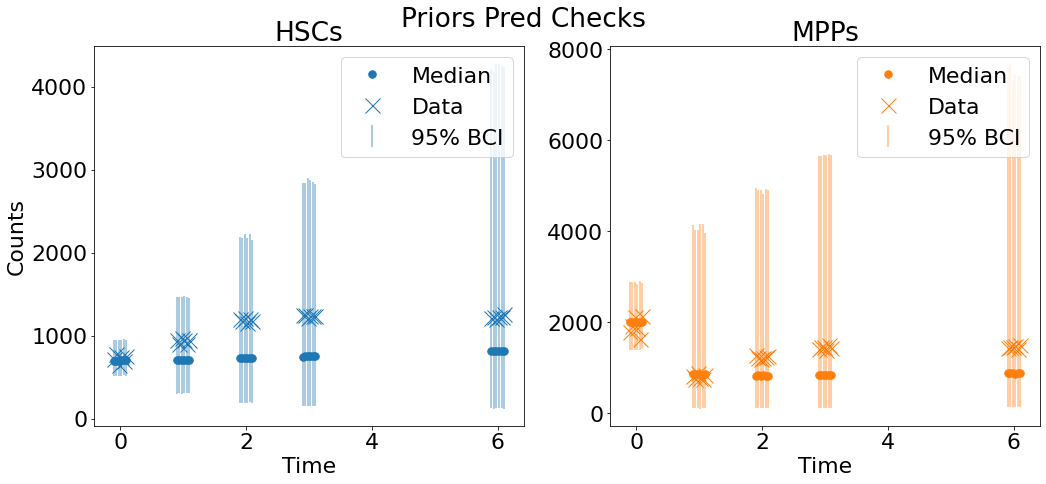

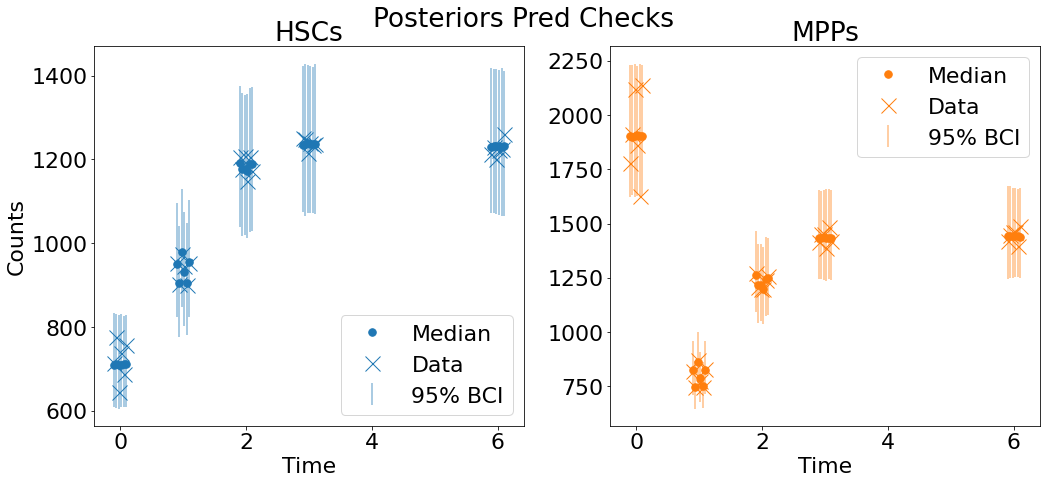

In [ ]:
col = [u'#1f77b4',u'#ff7f0e']
data_pert = ynoisy_df

"""PRIORS"""

type_sim = 'Priors'
df_cols = [col for col in df_priors_y_tilde_summ.columns if col.endswith('.1')]

yerr_priors = [df_priors_y_tilde_summ.loc['50%', df_cols].values
        - df_priors_y_tilde_summ.loc['2.5%', df_cols].values,
        df_priors_y_tilde_summ.loc['97.5%', df_cols].values
        - df_priors_y_tilde_summ.loc['50%', df_cols].values]

plt.subplots(1,2,figsize=(15,7))
plt.subplot(1,2,1)
plt.errorbar(time_pert, df_priors_y_tilde_summ.loc['50%', df_cols].values, 
         yerr=yerr_priors, fmt="none", alpha=0.5, col=col[0], label="95% BCI")
plt.plot(time_pert, df_priors_y_tilde_summ.loc['50%', df_cols], ".", 
         color=col[0], label="Median", markersize=15)
plt.plot(time_pert, data_pert.loc[:,'HSCs'],"x", color=col[0], 
         label="Data", markersize=15)
plt.legend(loc=0)#, bbox_to_anchor=(1.05, 1));
plt.title('HSCs')
plt.ylabel('Counts')
plt.xlabel('Time')


df_cols = [col for col in df_priors_y_tilde_summ.columns if col.endswith('.2')]

yerr_priors = [df_priors_y_tilde_summ.loc['50%', df_cols].values
        - df_priors_y_tilde_summ.loc['2.5%', df_cols].values,
        df_priors_y_tilde_summ.loc['97.5%', df_cols].values
        - df_priors_y_tilde_summ.loc['50%', df_cols].values]

plt.subplot(1,2,2)
plt.errorbar(time_pert, df_priors_y_tilde_summ.loc['50%', df_cols].values, 
         yerr=yerr_priors, fmt="none", alpha=0.5, color=col[1], label="95% BCI")
plt.plot(time_pert, df_priors_y_tilde_summ.loc['50%', df_cols], ".", 
         color=col[1], label="Median", markersize=15)
plt.plot(time_pert, data_pert.loc[:,'MPPs'],"x", color=col[1], 
         label="Data", markersize=15)
plt.legend(loc=0)#, bbox_to_anchor=(1.05, 1));
plt.title('MPPs')

plt.xlabel('Time')
plt.tight_layout()
plt.suptitle(f'{type_sim} Pred Checks')


"""POSTERIORS"""

type_sim = 'Posteriors'
df_cols = [col for col in df_priors_y_tilde_summ.columns if col.endswith('.1')]

yerr_posteriors = [df_posteriors_y_tilde_summ.loc['50%', df_cols].values
        - df_posteriors_y_tilde_summ.loc['2.5%', df_cols].values,
        df_posteriors_y_tilde_summ.loc['97.5%', df_cols].values
        - df_posteriors_y_tilde_summ.loc['50%', df_cols].values]

plt.subplots(1,2,figsize=(15,7))
plt.subplot(1,2,1)
plt.errorbar(time_pert, df_posteriors_y_tilde_summ.loc['50%', df_cols].values, 
         yerr=yerr_posteriors, fmt="none", alpha=0.5, col=col[0], label="95% BCI")
plt.plot(time_pert, df_posteriors_y_tilde_summ.loc['50%', df_cols], ".", 
         color=col[0], label="Median", markersize=15)
plt.plot(time_pert, data_pert.loc[:,'HSCs'],"x", color=col[0], 
         label="Data", markersize=15)
plt.legend(loc=0)#, bbox_to_anchor=(1.05, 1));
plt.title('HSCs')
plt.ylabel('Counts')
plt.xlabel('Time')


df_cols = [col for col in df_priors_y_tilde_summ.columns if col.endswith('.2')]

yerr_posteriors = [df_posteriors_y_tilde_summ.loc['50%', df_cols].values
        - df_posteriors_y_tilde_summ.loc['2.5%', df_cols].values,
        df_posteriors_y_tilde_summ.loc['97.5%', df_cols].values
        - df_posteriors_y_tilde_summ.loc['50%', df_cols].values]


plt.subplot(1,2,2)
plt.errorbar(time_pert, df_posteriors_y_tilde_summ.loc['50%', df_cols].values, 
         yerr=yerr_posteriors, fmt="none", alpha=0.5, color=col[1], label="95% BCI")
plt.plot(time_pert, df_posteriors_y_tilde_summ.loc['50%', df_cols], ".", 
         color=col[1], label="Median", markersize=15)
plt.plot(time_pert, data_pert.loc[:,'MPPs'],"x", color=col[1], label="Data", markersize=15)
plt.legend(loc=0)#, bbox_to_anchor=(1.05, 1));
plt.title('MPPs')

plt.xlabel('Time')
plt.tight_layout()
plt.suptitle(f'{type_sim} Pred Checks')


### Prior and Posterior ODE solutions 

In [ ]:
time_ode = ytrue_df.time.values
NUM_ODE_SOLS = 40
ix_ode_sols = np.random.choice(range(NUM_SAMPLING), size=NUM_ODE_SOLS, 
                               replace=False)

In [ ]:
df_posteriors = pd.read_csv(zip_posteriors, comment='#')
print(df_posteriors.shape)
df_cols = [col for col in df_posteriors.columns if 
           (col.startswith('y_hat_tilde') or col.startswith('mu'))]
df_posteriors = df_posteriors.loc[:, df_cols]
df_posteriors = df_posteriors.loc[NUM_WARMUP:, :]
print(df_posteriors.shape)
df_posteriors = df_posteriors.iloc[ix_ode_sols, :]
df_posteriors = df_posteriors.reset_index(drop=True)
df_posteriors.head()
print(df_posteriors.shape)
df_posteriors.head()

(6000, 3940)
(5000, 152)
(40, 152)


,y_hat_tilde.1.1,y_hat_tilde.2.1,y_hat_tilde.3.1,y_hat_tilde.4.1,y_hat_tilde.5.1,y_hat_tilde.6.1,y_hat_tilde.7.1,y_hat_tilde.8.1,y_hat_tilde.9.1,y_hat_tilde.10.1,...,y_hat_tilde.68.2,y_hat_tilde.69.2,y_hat_tilde.70.2,y_hat_tilde.71.2,y_hat_tilde.72.2,y_hat_tilde.73.2,y_hat_tilde.74.2,y_hat_tilde.75.2,mu.1,mu.2
0,673.366,679.748,696.844,721.332,750.869,783.761,818.737,854.810,891.184,927.201,...,1435.38,1435.40,1435.41,1435.42,1435.43,1435.44,1435.44,1435.45,682.478,1977.52
1,728.129,733.358,748.337,770.224,796.921,826.855,858.810,891.822,925.105,958.010,...,1430.76,1430.79,1430.81,1430.83,1430.85,1430.87,1430.88,1430.89,736.550,1896.81
2,656.497,666.322,687.294,715.477,748.251,783.820,820.891,858.491,895.855,932.359,...,1433.26,1433.26,1433.26,1433.27,1433.27,1433.27,1433.27,1433.27,663.861,1955.06
3,697.257,704.944,721.960,745.565,773.764,805.064,838.317,872.613,907.208,941.480,...,1440.28,1440.30,1440.32,1440.34,1440.36,1440.37,1440.38,1440.39,702.715,1826.94
4,706.114,713.231,729.206,751.420,777.967,807.436,838.748,871.059,903.685,936.061,...,1457.76,1457.78,1457.80,1457.82,1457.84,1457.85,1457.87,1457.88,711.500,1853.36


In [ ]:
df_priors = pd.read_csv(zip_priors, comment='#')
print(df_priors.shape)
df_cols = [col for col in df_posteriors.columns if 
           (col.startswith('y_hat_tilde') or col.startswith('mu'))]
df_priors = df_priors.loc[:, df_cols]
df_priors = df_priors.iloc[NUM_WARMUP:, :]
print(df_priors.shape)
df_priors = df_priors.iloc[ix_ode_sols, :]
df_priors = df_priors.reset_index(drop=True)
print(df_priors.shape)
df_priors.head()

(6000, 3940)
(5000, 152)
(40, 152)


,y_hat_tilde.1.1,y_hat_tilde.2.1,y_hat_tilde.3.1,y_hat_tilde.4.1,y_hat_tilde.5.1,y_hat_tilde.6.1,y_hat_tilde.7.1,y_hat_tilde.8.1,y_hat_tilde.9.1,y_hat_tilde.10.1,...,y_hat_tilde.68.2,y_hat_tilde.69.2,y_hat_tilde.70.2,y_hat_tilde.71.2,y_hat_tilde.72.2,y_hat_tilde.73.2,y_hat_tilde.74.2,y_hat_tilde.75.2,mu.1,mu.2
0,690.121,690.921,691.936,693.082,694.298,695.541,696.782,698.000,699.180,700.315,...,1932.630,1932.710,1932.780,1932.85,1932.910,1932.960,1933.020,1933.070,689.653,1918.05
1,632.124,628.120,624.616,621.569,618.943,616.702,614.815,613.252,611.986,610.993,...,1274.470,1277.170,1279.850,1282.51,1285.130,1287.730,1290.300,1292.840,636.671,2058.35
2,655.246,653.077,652.903,654.304,656.945,660.557,664.924,669.871,675.256,680.963,...,2039.300,2041.530,2043.650,2045.64,2047.530,2049.310,2051.000,2052.590,659.940,2620.99
3,639.430,630.706,622.220,613.969,605.951,598.160,590.593,583.242,576.102,569.166,...,879.089,873.541,868.089,862.73,857.461,852.281,847.187,842.177,648.391,1740.82
4,691.858,710.666,732.567,756.913,783.246,811.242,840.668,871.357,903.185,936.060,...,3251.420,3268.670,3284.590,3299.24,3312.700,3325.020,3336.290,3346.570,677.061,1957.90


##### Plot

Text(0.5, 0.98, 'Posteriors ODE Solutions')

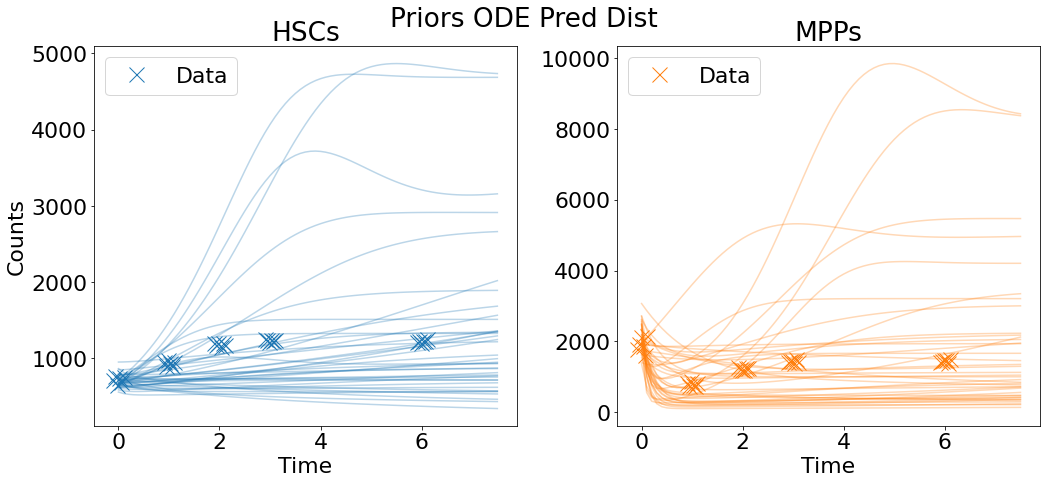

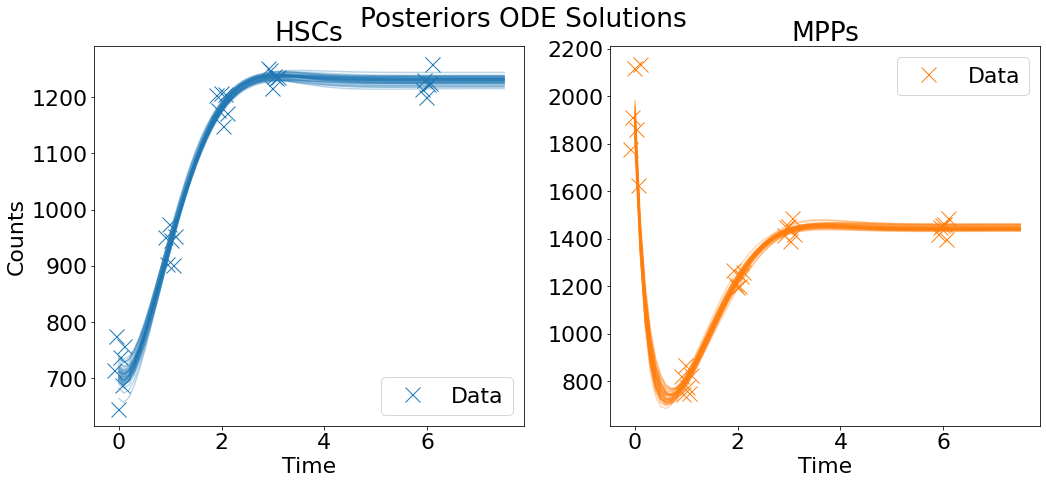

In [ ]:
col = [u'#1f77b4',u'#ff7f0e']

type_sim = 'Priors'
df_cols = [col for col in df_priors_y_tilde_summ.columns if col.endswith('.1')]

plt.subplots(1,2,figsize=(15,7))
plt.subplot(1,2,1)
df_col_ode_sol = [col for col in df_priors.columns if 
                  (col.startswith('y_hat_tilde') and col.endswith('.1'))]
for ode_sol_ix in range(NUM_ODE_SOLS):
  ode_sol = np.append(df_priors.loc[ode_sol_ix, 'mu.1'].tolist(),
              df_priors.loc[ode_sol_ix, df_col_ode_sol].values)
  plt.plot(time_ode, ode_sol, "-", color=col[0],alpha=0.3)
plt.plot(time_pert, data_pert.loc[:,'HSCs'],"x", color=col[0], 
         label="Data", markersize=15)

plt.legend(loc=0)
plt.title('HSCs')
plt.ylabel('Counts')
plt.xlabel('Time')

df_cols = [col for col in df_priors_y_tilde_summ.columns if col.endswith('.2')]

plt.subplot(1,2,2)
df_col_ode_sol = [col for col in df_priors.columns if 
                  (col.startswith('y_hat_tilde') and col.endswith('.2'))]
for ode_sol_ix in range(NUM_ODE_SOLS):
  ode_sol = np.append(df_priors.loc[ode_sol_ix, 'mu.2'].tolist(),
              df_priors.loc[ode_sol_ix, df_col_ode_sol].values)
  plt.plot(time_ode, ode_sol, "-", color=col[1],alpha=0.3)
plt.plot(time_pert, data_pert.loc[:,'MPPs'],"x", color=col[1], 
         label="Data", markersize=15)
plt.legend(loc=0)#, bbox_to_anchor=(1.05, 1));
plt.title('MPPs')

plt.xlabel('Time')
plt.tight_layout()
plt.suptitle(f'{type_sim} ODE Pred Dist')


""""""

type_sim = 'Posteriors'
df_cols = [col for col in df_priors_y_tilde_summ.columns if col.endswith('.1')]

plt.subplots(1,2,figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(time_pert, data_pert.loc[:,'HSCs'],"x", color=col[0], 
         label="Data", markersize=15)
df_col_ode_sol = [col for col in df_posteriors.columns if 
                  (col.startswith('y_hat_tilde') and col.endswith('.1'))]
for ode_sol_ix in range(NUM_ODE_SOLS):
  ode_sol = np.append(df_posteriors.loc[ode_sol_ix, 'mu.1'].tolist(),
              df_posteriors.loc[ode_sol_ix, df_col_ode_sol].values)
  plt.plot(time_ode, ode_sol, "-", color=col[0],alpha=0.3)
plt.legend(loc=0)#, bbox_to_anchor=(1.05, 1));
plt.title('HSCs')
plt.ylabel('Counts')
plt.xlabel('Time')


df_cols = [col for col in df_priors_y_tilde_summ.columns if col.endswith('.2')]

plt.subplot(1,2,2)
plt.plot(time_pert, data_pert.loc[:,'MPPs'],"x", color=col[1], label="Data", 
         markersize=15)
df_col_ode_sol = [col for col in df_posteriors.columns if 
                  (col.startswith('y_hat_tilde') and col.endswith('.2'))]
for ode_sol_ix in range(NUM_ODE_SOLS):
  ode_sol = np.append(df_posteriors.loc[ode_sol_ix, 'mu.2'].tolist(),
              df_posteriors.loc[ode_sol_ix, df_col_ode_sol].values)
  plt.plot(time_ode, ode_sol, "-", color=col[1],alpha=0.3)
plt.legend(loc=0)#, bbox_to_anchor=(1.05, 1));
plt.title('MPPs')

plt.xlabel('Time')
plt.tight_layout()
plt.suptitle(f'{type_sim} ODE Solutions')

## (RUN) Load simulated MCMC samples and re-build Stan fit object

In [71]:
%cd /home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_before/

/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_before


In [72]:
r_run("""Sys.setenv(MAKEFLAGS = "-j16")""") # 16 cores used in R

1


In [73]:
mcmc_config = dict(MCMC_type='Stan', num_chains=1)

fit, _ = load_zip_csv_samples_file(
          mcmc_config=mcmc_config,
          file_name='Stan_0_nparam_57_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc',
          file_zip='Stan_0_nparam_57_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc.zip',
          path=work_dir_demo_simulated_before,
          samples_type="posteriors",
          fit_name="fit"
)



>>>>>>>LOADING Stan posteriors CSV SAMPLES FROM ZIP!<<<<<<

[1]
 "Unzip zip file: "                                                           
 "Stan_0_nparam_57_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc.zip"


[1]
 "path is"                                                                                            
 "/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_before/"


[1]
 "pattern:"


[1]
 "Stan_0_nparam_57_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc.csv"


[1]
 "Loading CSV FILES:"


[1]
 "/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_before//Stan_0_nparam_57_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc.csv"


[1]
 "Sucessfully loaded posteriors csv samples into R env"


[1]
 "Warning: Removed csv files"




>>>>>>>SUCESSFULLY LOADED Stan posteriors CSV SAMPLES 
/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated

# Utility calculations

## Calculate marginal likelihood

Load `rstan_data` dictionary first

In [ ]:
#First create an empty model when loading previous samples from Stan fit object
new_mod = rstan.sampling(stan_model,
                        data=rstan_data,
                        chains=0,
                        verbose=False,
                        show_messages=False,
                        open_progress=False) #no html file opened for inspection
bridge = bridge_sampler(fit,
                        new_mod,
                        repetitions=design['num_ML'],
                        cores=16,
                        silent=False,
                        verbose=True)
r_global["bridge"] = bridge
r_run('saveRDS(bridge, file="bridge_object.RDS")')

### (RUN) Load Bridge Sampling object

In [74]:
r_run('bridge = readRDS(file="bridge_object.RDS")')
bridge = r_run('bridge')

In [75]:
bridge_error = error_measures(bridge)
r_global["bridge_error"] = bridge_error
print(bridge) 
print(bridge_error)
run_conf['NUM_SAMPLES_BRIDGE'] = len(bridge[0])

Median of 5 bridge sampling estimates
of the log marginal likelihood: -22929.96
Range of estimates: -22948.46 to -22917.77
Interquartile range: 0.32189
Method: normal

$min
[1] -22948.46

$max
[1] -22917.77

$IQR
[1] 0.321893




## Compute KL-divergence between prior and posterior distributions

### Create KL arrays and get samples

In [76]:
run_conf

{'num_MCMC_iter': 5000,
 'num_chains': 2,
 'num_warmup': 1000,
 'create_file_samples_csv': True,
 'MCMC_type': 'Stan',
 'priors_only': 0,
 'seed': 12345,
 'verbose': 0,
 'file_samples_priors_csv': '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_in_demo/Stan_samples_priors.csv',
 'num_samples_MCMC': 8000,
 'fit_priors_ignored_params': ['y_hat',
  'log_theta_raw',
  'log_mu_raw',
  'log_ylatent_tc_raw',
  'log_ylatent_sc_raw'],
 'pars_ode_noise': ['p0max',
  'eta1',
  'eta2maxbar',
  'gam1',
  'gam5',
  'sigmate',
  'sigmabe',
  'mu',
  'lp__'],
 'pars_ylatent': ['ylatent_tc', 'ylatent_sc'],
 'file_samples_posteriors_csv': '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/Demo/simulated_in_demo/Stan_samples_posteriors.csv',
 'fit_ignored_params': ['y_hat'],
 'NUM_SAMPLES_BRIDGE': 5}

In [77]:
dims_kl_arrays = [run_conf['num_samples_MCMC'], run_conf['NUM_SAMPLES_BRIDGE']]

numer_bridge = np.empty(dims_kl_arrays)
out_bridge = np.empty(dims_kl_arrays)
denom = np.empty(dims_kl_arrays)

run_conf['num_latent_var'] = stan_data["N_obs_post_ic"]*NUM_CELL_TYPES
run_conf['num_param'] = (
            NUM_ODE_PARAMS # p0, eta1, eta2, gam1, gam5,
            + NUM_ERROR_SIGMAS #sigmabe sigmate 
            + NUM_ODE_IC_MUS # mu1 mu2 
            + run_conf['num_latent_var'] # ylatents
)

In [78]:
samples_raw = extract(fit, permuted=True)
samples = dict(zip(samples_raw.names, list(samples_raw)))

### Calculate KL

In [ ]:
for j in range(run_conf['NUM_SAMPLES_BRIDGE']):
    for i in range(int(run_conf['num_samples_MCMC'])):
        val = np.r_[np.r_[samples["log_theta_raw"]][i,:],
                    np.r_[samples["log_sigma_raw"]][i,:],
                    np.r_[samples["log_mu_raw"]][i,:],
                    np.r_[samples["log_ylatent_sc_raw"]][i,:],
                    np.r_[samples["log_ylatent_tc_raw"]][i,:]]
        numer_bridge[i,j] = samples["lp__"][i] - bridge[0][j]
        
        #Evaluate priors on a uncorrelated multivariate normal distribution
        denom[i, j] = mvn.logpdf(x=val, 
                                mean=np.r_[[0]*run_conf['num_param']],
                                cov=np.diag([1]*run_conf['num_param']))
        
        out_bridge[i,j] = numer_bridge[i,j] - denom[i,j]

### Calculate marginal KLs

In [ ]:
params_dims_dict = dict(log_theta_raw=NUM_ODE_PARAMS,
                        log_sigma_raw=NUM_ERROR_SIGMAS,
                        log_mu_raw=NUM_ODE_IC_MUS,
                        log_ylatent_sc_raw=run_conf['num_latent_var']//NUM_CELL_TYPES,
                        log_ylatent_tc_raw=run_conf['num_latent_var']//NUM_CELL_TYPES)

KL_indiv = np.empty((run_conf['num_samples_MCMC'], run_conf['num_param']))

In [ ]:
def fit_density_kernel(samples, param_vect, param_ix):
    return gaussian_kde(np.r_[samples[param_vect]][:, param_ix])

def get_KL_single_param(kernel, param_vect, sample, param_ix):
    val = np.r_[samples[param_vect]][sample, param_ix]
    return (kernel.logpdf(val) - mvn.logpdf(x=val, mean=0, cov=1))

In [ ]:
col_ix = 0

for key, val in params_dims_dict.items():
  for param_ix in range(val):
    kernel = fit_density_kernel(samples=samples, 
                                param_vect=key, 
                                param_ix=param_ix)

    for sample_ix in range(run_conf['num_samples_MCMC']):
      KL_indiv[sample_ix, col_ix] = get_KL_single_param(kernel=kernel,
                                            param_vect=key,
                                            sample=sample_ix,
                                            param_ix=param_ix)
    col_ix += 1

In [ ]:
estimate_bridge = np.median(out_bridge)
estimate_bridge_indiv = np.median(KL_indiv)

estimate_bridge_medians = np.median(out_bridge, axis=0)
estimate_kl_median_indiv = np.median(KL_indiv, axis=0)

kl_estimates = dict(bridge=estimate_bridge,
                    bridge_repetitions_median=estimate_bridge_medians,
                    kl_median_indiv=estimate_kl_median_indiv)



### KL estimates

In [ ]:
kl_estimates

{'bridge': 23176.808644534773,
 'bridge_repetitions_median': array([23176.72146699, 23164.52249839, 23176.68739478, 23177.00928774,
        23195.22034597]),
 'kl_median_indiv': array([ 3.80539296e+00,  2.00793102e+00,  1.76332938e+00,  4.84347720e+00,
         2.48451419e+00,  1.54382986e+00,  2.21441693e+00,  1.33874151e+00,
         1.54436702e+00,  7.80405024e-01,  1.21327435e+00,  1.13487307e+00,
         8.44554298e-01,  1.16271368e+00,  7.89999434e-01,  7.50033516e-01,
         4.94349070e-01,  4.64840450e-01,  7.06238844e-01,  4.16575987e-01,
         4.62406786e-01,  5.75847531e-02,  7.29547495e-02,  4.13795386e-02,
         1.84673335e-02,  2.31277423e-01, -2.85032136e-02, -8.45157523e-03,
         2.85470407e-03,  4.49229315e-04,  1.48333076e-03, -4.70024813e-03,
        -4.15440766e-03,  6.78329981e-03,  1.03843421e-02,  3.37386041e-02,
        -9.73329280e-03,  5.01851404e-02,  9.72967241e-03,  5.93398797e-02,
         7.43413094e-03,  2.84161531e-02,  1.10654845e-01, -7.5

# Multiple Designs

## Load simulated MCMC zip samples files

In [ ]:
print(work_dir_src)
temp_utils = 'temp_utils/'
dpts_3_times_06 = work_dir_src + 'dpts_3_times_06/'
dpts_4_times_036 = work_dir_src + 'dpts_4_times_036/'
dpts_6_times_01236 = work_dir_src + 'dpts_6_times_01236/'

/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/


In [ ]:
all_files = glob.glob(dpts_3_times_06 + temp_utils+ 'Stan_*_Utility.csv')
all_files = [file for file in all_files if not ('_-' in file)]
all_files = natsorted(all_files)
print(len(all_files))

50


In [ ]:
design = 'dpts_3_times_06'
path = work_dir_src + design + '/' + temp_utils + 'Stan_*_Utility.csv'
path

'/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/dpts_3_times_06/temp_utils/Stan_*_Utility.csv'

In [ ]:
designs = ['dpts_3_times_06', 'dpts_4_times_036', 'dpts_6_times_01236']
df_all = pd.DataFrame(index=range(50), columns=designs)

In [ ]:
TOT_SIMULATIONS = 50
designs = ['dpts_3_times_06', 'dpts_4_times_036', 'dpts_6_times_01236']
df_all = pd.DataFrame(index=range(TOT_SIMULATIONS), columns=designs)
df_all.index.name = 'UID'

for design in designs:  
  path = work_dir_src + design + '/' + temp_utils + 'Stan_*_Utility.csv'
  all_files = glob.glob(path)
  all_files = [file for file in all_files if not ('_-' in file)] #filter out negative index simulations
  all_files =  natsorted(all_files)
  print('Total simulations: ', len(all_files), f' for design: {design}')

  dfs = []

  for file in all_files:  
    df = pd.read_csv(file, index_col=None, header=None)
    dummy = file.split(work_dir_src + design + '/temp_utils/Stan_')
    sim_num = int(dummy[-1].split('_')[0])
    df = df.rename(index={0:sim_num})
    dfs.append(df)

  df = pd.concat(dfs, axis=0, ignore_index=True)
  df = df.rename(columns={0:design})
  df.index.name = 'UID'

  df_all = df_all.fillna(df)
  df_all[design] = pd.to_numeric(df_all[design])


print(df_all.head())
df_all.to_csv(work_dir_src + design + '/temp_utils/utilities.csv')

Total simulations:  50  for design: dpts_3_times_06
Total simulations:  49  for design: dpts_4_times_036
Total simulations:  44  for design: dpts_6_times_01236
     dpts_3_times_06  dpts_4_times_036  dpts_6_times_01236
UID                                                       
0          11.628671         18.336369           39.719985
1           9.152389         55.598946           43.031335
2          12.750651         23.412693           39.790024
3          13.750494         24.483195           35.240807
4          13.953980         21.634495           34.711286


## Get Summary of utilities

In [ ]:
df_summary = df_all.describe(percentiles=[0.025,0.25,0.5,0.75,0.975])
df_summary

,dpts_3_times_06,dpts_4_times_036,dpts_6_times_01236
count,50.000000,49.000000,44.000000
mean,12.024237,21.601014,39.497784
std,3.653584,7.868185,14.611554
min,8.097499,11.185662,16.846441
2.5%,8.204785,11.575629,18.770915
25%,9.829271,16.736446,28.316652
50%,11.679217,20.218203,38.766108
75%,13.255129,24.414083,46.676510
97.5%,14.827225,36.921464,73.084220
max,33.520833,55.598946,76.969813


In [ ]:
sim_ix = 19
sim_ix_numb = f"numb_{sim_ix}"
NUM_WARMUP = 1000
NUM_SAMPLING = 5000

df_params_cols = ['lp__', 'p0max', 'eta1', 'eta2maxbar', 'gam1', 'gam5', 
           'sigmabe','sigmate', 'mu.1', 'mu.2']


paths_dict = dict(dpts_3_times_06=dict(days_data=[0,6],dpts=3), 
                  dpts_4_times_036=dict(days_data=[0,3,6],dpts=4), 
                  dpts_6_times_01236=dict(days_data=[0,1,2,3,6],dpts=6))

MCMC_dict_all = dict()

design_dict = dict(days_data=[0,6], dpts=3)
design_dict['N_rep_pday'] =  [design_dict['dpts']] * len(design_dict['days_data'])
MCMC_dict_all['dpts_3_times_06'] = design_dict

design_dict = dict(days_data=[0,3,6], dpts=4)
design_dict['N_rep_pday'] =  [design_dict['dpts']] * len(design_dict['days_data'])
MCMC_dict_all['dpts_4_times_036'] = design_dict

design_dict = dict(days_data=[0,1,2,3,6], dpts=6)
design_dict['N_rep_pday'] =  [design_dict['dpts']] * len(design_dict['days_data'])
MCMC_dict_all['dpts_6_times_01236'] = design_dict


for design in list(paths_dict.keys()):
  if design == 'dpts_3_times_06':
    num_params = 15
  elif design == 'dpts_4_times_036':
    num_params = 25
  elif design == 'dpts_6_times_01236':
    num_params = 57
  work_dir_demo_simulated_before = work_dir_src + f"{design}/"
  paths_dict[design]['zip_priors'] = work_dir_demo_simulated_before + f"numb_-1/Stan_-1_nparam_{num_params}_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc_priors.zip"#'Stan_-1_nparam_57_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc_priors.zip'
  paths_dict[design]['zip_posteriors'] = work_dir_demo_simulated_before + f"{sim_ix_numb}/Stan_{sim_ix}_nparam_{num_params}_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc.zip"
  paths_dict[design]['csv_params_sets'] = work_dir_demo_simulated_before + "param_sets.csv"
  paths_dict[design]['csv_ynoisy'] = work_dir_demo_simulated_before + f"{design}_dataset_{sim_ix}.csv"
  paths_dict[design]['csv_ytrue'] = work_dir_demo_simulated_before + f"{design}_dataset_{sim_ix}_true.csv"
paths_dict

{'dpts_3_times_06': {'days_data': [0, 6],
  'dpts': 3,
  'zip_priors': '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/dpts_3_times_06/numb_-1/Stan_-1_nparam_15_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc_priors.zip',
  'zip_posteriors': '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/dpts_3_times_06/numb_19/Stan_19_nparam_15_nsamp_6000_nchain_1_nwarm_1000_6param_lineage_fit_mcmc.zip',
  'csv_params_sets': '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/dpts_3_times_06/param_sets.csv',
  'csv_ynoisy': '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/dpts_3_times_06/dpts_3_times_06_dataset_19.csv',
  'csv_ytrue': '/home/luisdm/Github/Auto-MCMC/BayesCML/Six_parameter_lineage_model_synthetic/dpts_3_times_06/dpts_3_times_06_dataset_19_true.csv'},
 'dpts_4_times_036': {'days_data': [0, 3, 6],
  'dpts': 4,
  'zip_priors': '/home/luisdm/Github/Auto-MCMC/BayesCML/Si

## Get MCMC samples dataframes

In [ ]:
def get_df_MCMC(paths_dict, design, MCMC_dict):
  print(design)
  new_dict = dict()

  new_dict['ynoisy_df'] = pd.read_csv(paths_dict[design]['csv_ynoisy'], header=None)
  new_dict['ynoisy_df'].columns = ['HSCs', 'MPPs']
  #new_dict['ynoisy_df']

  new_dict['param_sets_df'] = pd.read_csv(paths_dict[design]['csv_params_sets'], header=None)
  new_dict['true_values'] = {df_params_cols[ix] : new_dict['param_sets_df'].iloc[0, ix-1] for ix in range(1, len(df_params_cols))}
  new_dict['true_values']['lp__'] = np.nan
  #new_dict['true_values']


  new_dict['df_posteriors'] = pd.read_csv(paths_dict[design]['zip_posteriors'], comment='#')
  print(new_dict['df_posteriors'].shape)

  df_ode_cols = [col for col in new_dict['df_posteriors'].columns if 
           (col.startswith('y_hat_tilde') or col.startswith('mu'))]

  new_dict['df_posteriors'] = new_dict['df_posteriors'].loc[:, new_dict['df_posteriors'].columns.isin(df_ode_cols)]
  new_dict['df_posteriors'] = new_dict['df_posteriors'].loc[NUM_WARMUP:, :]
  new_dict['df_posteriors'] = new_dict['df_posteriors'].reset_index(drop=True)
  print(new_dict['df_posteriors'].shape)
  new_dict['df_posteriors'].head()

  new_dict['df_priors'] = pd.read_csv(paths_dict[design]['zip_priors'], comment='#')
  print(new_dict['df_priors'].shape)
  new_dict['df_priors'] = new_dict['df_priors'].loc[:, new_dict['df_priors'].columns.isin(df_ode_cols)]
  new_dict['df_priors'] = new_dict['df_priors'].iloc[NUM_WARMUP:, :]
  new_dict['df_priors'] = new_dict['df_priors'].reset_index(drop=True)
  print(new_dict['df_priors'].shape)
  new_dict['df_priors'].head()

  new_dict['ytrue_df'] = pd.read_csv(paths_dict[design]['csv_ytrue'], header=None)
  new_dict['ytrue_df'].columns = ['time', 'HSCs', 'MPPs', 'flag']
  new_dict['ytrue_df'].head()
  new_dict['ytrue_df_reduced'] = new_dict['ytrue_df'][new_dict['ytrue_df'].flag == 1]

  new_dict['time_ode'] = new_dict['ytrue_df'].time.values

  ## Shift time so 95% intervals do not overlap
  time_pert = []
  for timepoints, dpts in zip(MCMC_dict['days_data'], MCMC_dict['N_rep_pday']):
      time_pert.append(
          np.linspace(timepoints - 0.1, timepoints + 0.1, dpts).tolist()
      )
  new_dict['time_pert'] = sum(time_pert,[])
  new_dict['ynoisy_df'].loc[:, 'time'] = new_dict['time_pert']
  return new_dict

In [ ]:
for design in designs:
  MCMC_dict_all[design]['df_MCMC'] = (
      get_df_MCMC(paths_dict, design=design, MCMC_dict=MCMC_dict_all[design])
  )

dpts_3_times_06
(6000, 658)
(5000, 152)
(6000, 658)
(5000, 152)
dpts_4_times_036
(6000, 1440)
(5000, 152)
(6000, 1440)
(5000, 152)
dpts_6_times_01236
(6000, 3940)
(5000, 152)
(6000, 3940)
(5000, 152)


In [ ]:
def plot_ode_solutions(cell_type, df_MCMC, ode_time, data=None, num_lines=40, xlabel=None, ylabel=None, legend=None, title=None):  
  if cell_type == "HSCs":
    var_suffix = ".1"
  elif cell_type == "MPPs":
    var_suffix = ".2"

  colors = {'HSCs':u'#1f77b4','MPPs':u'#ff7f0e'}

  df_cols = [col for col in df_MCMC.columns if col.endswith(var_suffix)]
  
  if not (data is None):
    plt.plot(data['time'], data[cell_type], "x", color=colors[cell_type], 
            label="Data", markersize=15)

  df_col_ode_sol = [col for col in df_MCMC.columns if 
                  (col.startswith('y_hat_tilde') and col.endswith(var_suffix))]
  
  for ode_sol_ix in range(num_lines):
    ode_sol = np.append(df_MCMC.loc[ode_sol_ix, 'mu'+ var_suffix].tolist(),
                df_MCMC.loc[ode_sol_ix, df_col_ode_sol].values)

    plt.plot(ode_time, ode_sol, "-", color=colors[cell_type], alpha=0.3)
  plt.xticks([0,1,2,3,4,5,6,7])
  if legend:
    plt.legend(loc=0);
  if ylabel:
    plt.ylabel(ylabel);
  if xlabel:
    plt.xlabel(xlabel);
  if title:
    plt.title(title);


## Plot ODE solutions per design

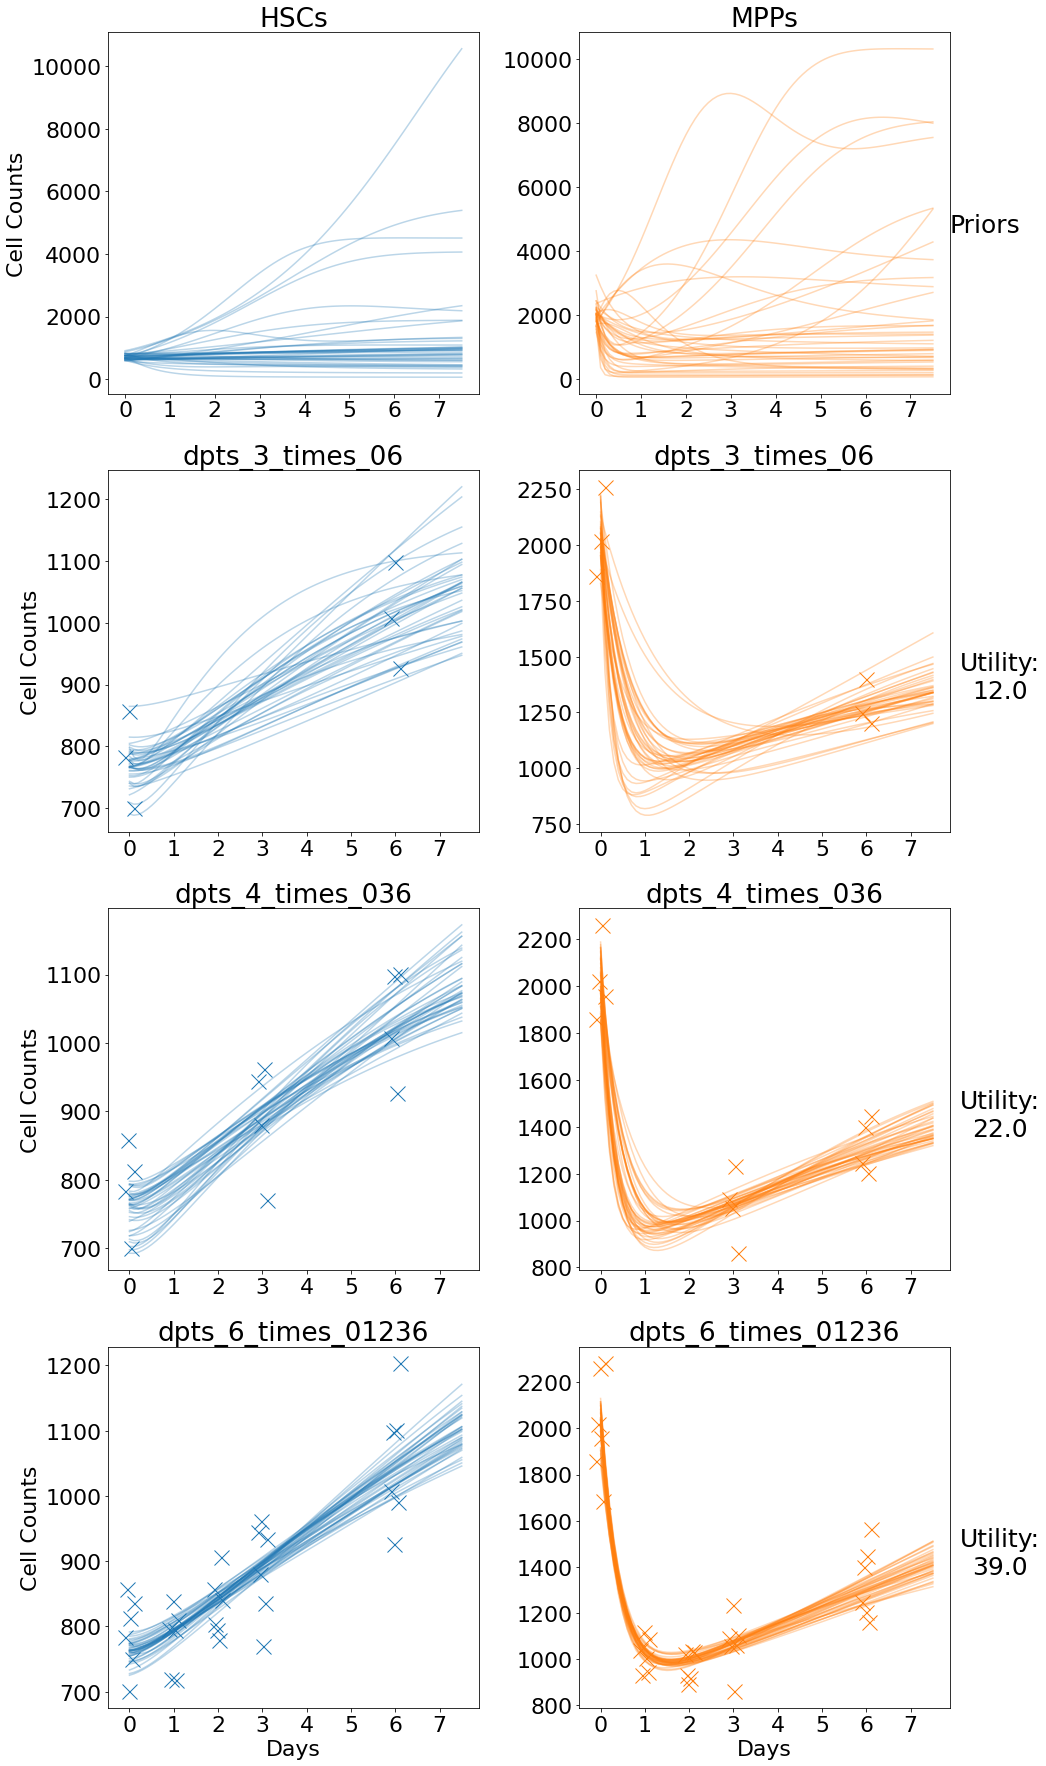

In [ ]:
plt.subplots(4, 2, figsize=(15, 25))

design = 'dpts_3_times_06'
subplot_ix = 1

for celltype in ['HSCs', 'MPPs']: 
  ax = plt.subplot(4, 2, subplot_ix)
  plot_ode_solutions(cell_type=celltype, 
                    df_MCMC=MCMC_dict_all[design]['df_MCMC']['df_priors'], 
                    ode_time=MCMC_dict_all[design]['df_MCMC']['time_ode'], 
                    title=celltype)
  if subplot_ix == 1:
    plt.ylabel('Cell Counts')
  if subplot_ix == 2: 
    plt.ylabel('Priors', rotation=0, fontsize=25, labelpad=35)
    ax.yaxis.set_label_position("right")
  subplot_ix += 1

for design in designs:
  plt.subplot(4, 2, subplot_ix)
  plot_ode_solutions(cell_type="HSCs", 
                    df_MCMC=MCMC_dict_all[design]['df_MCMC']['df_posteriors'], 
                    data=MCMC_dict_all[design]['df_MCMC']['ynoisy_df'], 
                    ode_time=MCMC_dict_all[design]['df_MCMC']['time_ode'],
                     title = f'{design}',
                     ylabel='Cell Counts')
  if design == designs[-1]:
    plt.xlabel('Days')

  ax = plt.subplot(4, 2, subplot_ix + 1)
  plot_ode_solutions(cell_type="MPPs", 
                    df_MCMC=MCMC_dict_all[design]['df_MCMC']['df_posteriors'], 
                    data=MCMC_dict_all[design]['df_MCMC']['ynoisy_df'], 
                    ode_time=MCMC_dict_all[design]['df_MCMC']['time_ode'],
                    title = f'{design}')
  utility = np.round(df_summary.loc['mean', design])
  plt.ylabel(f'Utility:\n{utility}', rotation=0, fontsize=25, labelpad=50)
  ax.yaxis.set_label_position("right")
  
  if design == designs[-1]:
    plt.xlabel('Days')
  subplot_ix += 2

plt.tight_layout()

In [ ]:
work_dir_data_analysis = "/home/luisdm/Github/Auto-MCMC/BayesCML/6_parameter_lineage_model_VanEttenData"
data = pd.read_csv(work_dir_data_analysis + "/data/cell_counts_van_etten_data.csv",
                   sep='\t', index_col=0)
data

,Time,HSC Control,MPP Control,HSC Perturbation,MPP Perturbation
0,0,7429.200000,15950.90,2174.260,15974.10
1,0,4417.120000,18162.50,1347.750,10782.00
2,0,5178.292683,20158.40,1176.340,15723.70
3,0,3729.671642,20022.40,2190.150,17497.70
4,0,1531.384615,7561.21,540.583,5722.46
5,0,2439.791304,9625.74,137.263,4975.79
6,0,NaN,NaN,85.800,7464.60
7,2,4568.590000,20763.20,1103.540,11812.50
8,2,1516.790000,18249.70,989.016,3711.79
9,2,NaN,NaN,881.319,4233.11


# Libraries info

## R libraries

In [81]:
print('R session info')
print(r_run("""library(utils); print(sessionInfo());"""))

R session info
R version 3.6.1 (2019-07-05)



Platform: 

x86_64-conda_cos6-linux-gnu (64-bit)



Running under: 

CentOS Linux 7 (Core)





Matrix products: 

default



BLAS/LAPACK: 

/home/luisdm/.conda/envs/tfgpu_rpy2_20200628/lib/libmkl_rt.so





locale:

 [1]
 LC_CTYPE=en_US.UTF-8      
 LC_NUMERIC=C              
 LC_TIME=en_US.UTF-8       
 LC_COLLATE=en_US.UTF-8    
 LC_MONETARY=en_US.UTF-8   
 LC_MESSAGES=en_US.UTF-8   
 LC_PAPER=en_US.UTF-8      
 LC_NAME=C                 
 LC_ADDRESS=C              
 LC_TELEPHONE=C            
 LC_MEASUREMENT=en_US.UTF-8
 LC_IDENTIFICATION=C       




attached base packages:

[1]
 tools    
 stats    
 graphics 
 grDevices
 utils    
 datasets 
 methods  
 base     



other attached packages:

[1]
 rstan_2.18.2        
 ggplot2_3.1.1       
 NCmisc_1.1.6        
 StanHeaders_2.18.1  
 bridgesampling_1.0-0



loaded via a namespace (and not attached):

 [1]
 Rcpp_1.0.1        
 pillar_1.3.1      
 compiler_3.6.1    
 plyr_1.8.4        

## Python libraries

In [83]:
!conda -V
!conda list

conda 4.7.10
# packages in environment at /home/luisdm/.conda/envs/tfgpu_rpy2_20200628:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_r-mutex                  1.0.0               anacondar_1  
_tflow_select             2.1.0                       gpu  
absl-py                   0.9.0                    py37_0  
arviz                     0.6.1                      py_0  
astunparse                1.6.3                      py_0  
attrs                     19.3.0                     py_0  
backcall                  0.2.0                      py_0  
binutils_impl_linux-64    2.33.1               he6710b0_7  
binutils_linux-64         2.33.1              h9595d00_15  
blas                      1.0                         mkl  
bleach                    3.1.5                      py_0  
blinker                   1.4                      py37_0  
brotlipy                  0.7.0           py37h7b6447c_1000  
b